<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Prototype Target Dashboard</b> <br>
Contact author: Douglas Tucker <br>
Last verified to run: 2024-06-28 <br>
LSST Science Pipelines version: Weekly 2024_26 <br>
Container size: medium <br>

**Description:** A prototype dashboard for exploring targets (and science programs) for a given night.  This initial version focuses on AuxTel observations, but should be useful for ComCom and LSSTcam commissioning, when there will be a greater diversity of observational programs than those provided by the survey scheduler during standard operations.

See Jira issue <a href=https://rubinobs.atlassian.net/browse/PREOPS-5002>PREOPS-5002</a>.

**Credit:** Based heavily on the <a href=https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/ana_auxtelprod_jn/spectractor_v3.1.0_May2024/ListOfExposures-hologram-oga.ipynb> List of Exposures at USDF in OGA</a> notebook by Sylvie Dagoret-Campagne.  This initial "Prototype Target Dashboard" notebook would not have been possible without it.

## 1. Introduction

### 1.1 Import Packages

In [1]:
import sys
import os
import io
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import healpy as hp
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler
import lsst.geom as geom

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.io import fits
from astropy.time import Time

import warnings

### 1.2. Define functions and parameters

Create a function to create a pandas DataFrame, df_grouped, that contains the results of performing a 2D groupby operation on a pandas DataFrame, df, and counts the number of entries in the col_count column for each (col_x, col_y).  One can choose to include a count of zero for cases where (col_x, col_y) have no entries in col_count (the default), or to exclude those cases.  The resulting pandas DataFrame, df_grouped, is also sorted by (col_x, col_y).

In [2]:
# Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values for help in creating this function!

def df2Dgroupby(df, col_x, col_y, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df_science.groupby([col_x, col_y])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y])
        )

    else:

        df_grouped = (
            df_science.groupby([col_x, col_y])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y])
        )
        
    return df_grouped

Let us also do the same, but for performing the `groupby` over 3 columns.  (Should just generalize this to `N` columns, but that can wait...) 

In [3]:
# Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values for help in creating this function!

def df3Dgroupby(df, col_x, col_y, col_z, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df_science.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y, col_z])
        )

    else:

        df_grouped = (
            df_science.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y, col_z])
        )
        
    return df_grouped

Create a function to plot an annotated headmap for a pandas DataFrame created by the above `df2Dgroupby` function.

In [4]:
# With a little help from https://seaborn.pydata.org/generated/seaborn.heatmap.html ...

def plotAnnotatedHeatMap_df2Dgroupby(df_grouped, col_index, col_column, col_values, title='Annotated Heatmap', cmap='Blues'):

    # Estimate a good figure size in x,y for the resulting plot...
    figsize_x = df_grouped[col_column].unique().size
    figsize_y = df_grouped[col_index].unique().size
    if figsize_y < 3:
        figsize_y = 1
    else:
        figsize_y = round(figsize_y/3)
    
    # Pivot the DataFrame to works with Seaborn heatmap...
    pivot_table = df_grouped.pivot(index=col_index, columns=col_column, values=col_values)
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
    #fig, ax = plt.subplots(figsize=(5, 15))
    #fig, ax = plt.subplots()

    # Plot the annoated heatmap...
    sns.heatmap(pivot_table, annot=True, cmap=cmap, linecolor='Black', linewidths=0.1, ax=ax)

    # Add labels and title and rotate the x tick labels by 90 degrees...
    ax.set_xlabel(col_column)
    ax.set_ylabel(col_index)
    ax.set_title(title)
    plt.xticks(rotation=90)

Create a function to perform a many-to-one match based on RA, DEC sky coordinates.

In [5]:
# Kudos to Claude-3.5-Sonnet AI from Poe.com fro this function!

def skyMatchCatManytoOne(df_a, df_a_ra_colname, df_a_dec_colname, df_b, df_b_ra_colname, df_b_dec_colname, max_sep_deg):

    from astropy.coordinates import SkyCoord # High-level coordinates
    from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
    from astropy.coordinates import Angle, Latitude, Longitude  # Angles
    from astropy import units as u
    from astropy.coordinates.matching import search_around_sky
    import numpy as np
    import pandas as pd

    # Create SkyCoord objects for both DataFrames
    coords_a = SkyCoord(ra=df_a[df_a_ra_colname].values*u.degree, dec=df_a[df_a_dec_colname].values*u.degree)
    coords_b = SkyCoord(ra=df_b[df_b_ra_colname].values*u.degree, dec=df_b[df_b_dec_colname].values*u.degree)

    # Set a maximum separation for matching (adjust as needed)
    max_sep_deg = max_sep_deg * u.degree

    # Perform the search
    idx_a, idx_b, d2d, _ = search_around_sky(coords_a, coords_b, max_sep_deg)

    # Create a DataFrame with the matches
    df_matches = pd.DataFrame({
        'idx_a': idx_a,
        'idx_b': idx_b,
        'separation': d2d.degree
    })

    # Group by idx_a and find the minimum separation for each
    best_matches = df_matches.loc[df_matches.groupby('idx_a')['separation'].idxmin()]

    # Create the final matched DataFrame, keeping all entries from df_a
    df_matched = df_a.copy()

    # Prepare the data from df_b to be joined
    df_b_matched = df_b.iloc[best_matches['idx_b']].copy()
    df_b_matched['idx_a'] = best_matches['idx_a'].values
    df_b_matched['separation'] = best_matches['separation'].values
    df_b_matched = df_b_matched.set_index('idx_a')

    # Perform the left join
    df_matched = df_matched.join(df_b_matched, rsuffix='_b')
    
    # Reset index if needed
    df_matched = df_matched.reset_index(drop=True)

    # Fill NaN values in the 'separation' column with a sentinel value (e.g., -1) to indicate no match
    df_matched['separation'] = df_matched['separation'].fillna(-1)

    # Optionally, you can add a boolean column to easily identify matched and unmatched rows
    df_matched['has_match'] = df_matched['separation'] != -1

    # Print some statistics
    print(f"Total entries in df_a: {len(df_a)}")
    print(f"Entries in df_a with matches: {df_matched['has_match'].sum()}")
    print(f"Entries in df_a without matches: {(~df_matched['has_match']).sum()}")

    return df_matched

Define some healpix tools.  I got this version from Sahar Allam on 2016-07-08, likely based on code from Alex Drlica-Wagner.

In [6]:
##################################
def radec2thetaphi(ra, dec):
    import numpy as np
    return (90-dec)*np.pi/180., ra*np.pi/180.

##################################
#DESDM uses nside=128, nest=True
#Alex Drlica Wagner's healpixelated Gaia DR2 on des40 uses nside=32, nest=False
def getipix(nside,ra,dec,nest=True):
    import healpy as hp
    theta, phi = radec2thetaphi(ra, dec)
    ipix = hp.pixelfunc.ang2pix(nside, theta, phi, nest)
    return ipix

##################################

Define a function to return the tract id, given the ra, dec and a skymap.

In [7]:
def find_tract(ra,dec,skymap):

    import lsst.geom as geom
    
    try:
        sky_point = geom.SpherePoint(ra * geom.degrees,
                                     dec * geom.degrees)

        tract = skymap.findTract(sky_point)
        tract = tract.tract_id
    
        del sky_point

    except:
        
        tract = -1
    
    return tract

Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:

In [8]:
warnings.filterwarnings("ignore")

Set default backend for afwDisplay to `matplotlib`:

In [9]:
afwDisplay.setDefaultBackend('matplotlib')

Set a few parameters to use later, when plotting:

In [10]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

This is a temporary fix to attach field names to the Ops Rehearsal 4 science exposures:

In [11]:
# Table of Ops Rehearsal 4 Fields from https://confluence.lsstcorp.org/pages/viewpage.action?pageId=259785406
ascii_table = """
Field                       RA          DEC     stellarDens     E_BV
Rubin_SV_095_-25           95.00      -25.00        2.92        0.05
Rubin_SV_125_-15          125.00      -15.00        3.78        0.06
DESI_SV3_R1               179.60        0.00        0.53        0.03
Rubin_SV_225_-40          225.00      -40.00       12.67        0.08
DEEP_A0                   216.00      -12.50        1.17        0.09
Rubin_SV_250_2            250.00        2.00        4.56        0.07
Rubin_SV_300_-41          300.00      -41.00        5.22        0.09
Rubin_SV_280_-48          280.00      -48.00       17.64        0.07
DEEP_B0                   310.00      -19.00        3.28        0.04
ELAIS_S1                    9.45      -44.00        0.56        0.01
XMM_LSS                    35.71       -4.75        0.47        0.03
ECDFS                      53.12      -28.10        0.61        0.01
COSMOS                    150.10        2.18        0.67        0.02
EDFS_A                     58.90      -49.31        0.75        0.01
EDFS_B                     63.60      -47.60        0.81        0.01"""

# Convert the string to a file-like object
ascii_io = io.StringIO(ascii_table)

# Read the ASCII table into a pandas DataFrame
df_field = pd.read_csv(ascii_io, delim_whitespace=True)

# Display df_field
df_field

,Field,RA,DEC,stellarDens,E_BV
0,Rubin_SV_095_-25,95.00,-25.00,2.92,0.05
1,Rubin_SV_125_-15,125.00,-15.00,3.78,0.06
2,DESI_SV3_R1,179.60,0.00,0.53,0.03
3,Rubin_SV_225_-40,225.00,-40.00,12.67,0.08
4,DEEP_A0,216.00,-12.50,1.17,0.09
5,Rubin_SV_250_2,250.00,2.00,4.56,0.07
6,Rubin_SV_300_-41,300.00,-41.00,5.22,0.09
7,Rubin_SV_280_-48,280.00,-48.00,17.64,0.07
8,DEEP_B0,310.00,-19.00,3.28,0.04
9,ELAIS_S1,9.45,-44.00,0.56,0.01


Let's add some healpix info to this table.  Let's aim for a couple different healpixel sizes:  one *very* roughly the area of a ComCam field-of-view (NSIDE=2^6=64) and one *very* roughly the area of an LSSTCam field-of-view (NSIDE=2^4=16).

In [12]:
# HPX64:  very roughly the area of a ComCam field-of-view (c. 0.5 sq deg)
nside=2**6
# Area in sq deg:
area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
# A rough measure of length in degrees: 
length = math.sqrt(area)
print(nside, area, length)

# HPX16:  very roughly the area of an LSSTCam field-of-view (c. 9.6 sq deg)
nside=2**4
# Area in sq deg:
area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
# A rough measure of length in degrees: 
length = math.sqrt(area)
print(nside, area, length)

64 0.8392936452111668 0.9161297098179748
16 13.428698323378669 3.6645188392718993


In [13]:
# Add healpix info
df_field.loc[:,'HPX64'] = getipix(64, df_field.loc[:,'RA'].values, df_field.loc[:,'DEC'].values)
df_field.loc[:,'HPX16'] = getipix(16, df_field.loc[:,'RA'].values, df_field.loc[:,'DEC'].values)

# Display df_field
df_field

,Field,RA,DEC,stellarDens,E_BV,HPX64,HPX16
0,Rubin_SV_095_-25,95.00,-25.00,2.92,0.05,20693,1293
1,Rubin_SV_125_-15,125.00,-15.00,3.78,0.06,40664,2541
2,DESI_SV3_R1,179.60,0.00,0.53,0.03,26965,1685
3,Rubin_SV_225_-40,225.00,-40.00,12.67,0.08,44035,2752
4,DEEP_A0,216.00,-12.50,1.17,0.09,44789,2799
5,Rubin_SV_250_2,250.00,2.00,4.56,0.07,31151,1946
6,Rubin_SV_300_-41,300.00,-41.00,5.22,0.09,47515,2969
7,Rubin_SV_280_-48,280.00,-48.00,17.64,0.07,47638,2977
8,DEEP_B0,310.00,-19.00,3.28,0.04,48730,3045
9,ELAIS_S1,9.45,-44.00,0.56,0.01,35388,2211


Define repo, collection, instrument, and day of observation to study:

In [14]:
## LATISS data from April 2024:
##repo = "/sdf/group/rubin/repo/main"
##repo="/sdf/group/rubin/repo/oga/"
##collection='LATISS/raw/all'
##instrument = 'LATISS'
##day_obs = 20240422

## Ops Rehearsal 3, "Intermittent Cumulative DRP: of the 3 nights of ops rehearsal 3 data
##  (https://confluence.lsstcorp.org/display/DM/Campaigns)
#repo = "/repo/embargo"
#collection='LSSTComCamSim/quickLook/24'
#instrument = 'LSSTComCamSim'
#day_obs = 20240404

# Ops Rehearsal 4 intra-night
#  (https://confluence.lsstcorp.org/display/DM/Campaigns)
repo = "embargo_or4"
collection = 'LSSTComCamSim/nightlyValidation/0'
instrument = 'LSSTComCamSim'
day_obs = 20240625

# The intra-night collection does not seem to have a skymap; 
#  so we will use the 10am collection to grab the skymap
lsst_distrib_tag = "w_2024_25"
collection_sky = """LSSTComCamSim/runs/nightlyValidation/%d/%s/DM-44966""" % (day_obs, lsst_distrib_tag)
skymap_name = 'ops_rehersal_prep_2k_v1'


Define columns to groupby and plot against each other:

In [15]:
col_sciprog = 'science_program'
#col_target = 'target'
#col_target = 'HPX8'  # HPX8 is used as a proxy for target_name or block
col_target = 'field_name'  # field_name is used as a proxy for target_name or block
col_filter = 'filter'
col_id = 'id'

## 2. Access data for this repo, collection, and day of observation

### 2.1 Instantiate butler and create registry

In [16]:
butler = dafButler.Butler(repo, collections=collection)
registry = butler.registry

Determine which dataset types exist in the collection.
(Based on material from `ops_rehearsal_comcam_analysis.ipynb`.)

In [17]:
i=0
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=collection).any(execute=False, exact=False):
        # Limit search results to the data products
        if ('_config' not in datasetType.name) and ('_log' not in datasetType.name) and ('_metadata' not in datasetType.name) and ('_resource_usage' not in datasetType.name):
            print(datasetType)
            i = i+1
print(i)

DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure)
DatasetType('packages', {}, Packages)
DatasetType('icSrc_schema', {}, SourceCatalog)
DatasetType('src_schema', {}, SourceCatalog)
DatasetType('icExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('icExpBackground', {band, instrument, day_obs, detector, physical_filter, visit}, Background)
DatasetType('icSrc', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog)
DatasetType('calexp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('calexpBackground', {band, instrument, day_obs, detector, physical_filter, visit}, Background)
DatasetType('calexpSummary_metrics', {band, instrument, day_obs, detector, physical_filter, visit}, MetricMeasurementBundle)
DatasetType('src', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog)
DatasetType('srcMatch', {band, instr

Let's see what metadata records (`dimensionRecords`) might be available.

In [18]:
print(butler.dimensions.getStaticDimensions())

{band, healpix1, healpix2, healpix3, healpix4, healpix5, healpix6, healpix7, healpix8, healpix9, healpix10, healpix11, healpix12, healpix13, healpix14, healpix15, healpix16, healpix17, htm1, htm2, htm3, htm4, htm5, htm6, htm7, htm8, htm9, htm10, htm11, htm12, htm13, htm14, htm15, htm16, htm17, htm18, htm19, htm20, htm21, htm22, htm23, htm24, instrument, skymap, day_obs, detector, group, physical_filter, subfilter, tract, visit_system, exposure, patch, visit}


What fields are available from the `exposure` dimension?

In [19]:
print(butler.registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  day_obs: int
  group: str
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  seq_num: int
  seq_start: int
  seq_end: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  can_see_sky: bool
  timespan: lsst.daf.butler.Timespan


Good!  We have some useful info here, including the `target_name` and the `science_program`.

Let's also see what fields are available from the `visit` dimension.

In [20]:
print(butler.registry.dimensions["visit"].RecordClass.fields)

visit: 
  instrument: str
  id: int
  day_obs: int
  physical_filter: str
  name: str
  seq_num: int
  exposure_time: float
  target_name: str
  observation_reason: str
  science_program: str
  azimuth: float
  zenith_angle: float
  region: lsst.sphgeom.Region
  timespan: lsst.daf.butler.Timespan


Not a whole lot more than what is available in the `exposure` dimension.  Let's ignore the `visit` dimension.

### 2.2 Read in information from the `exposure` dimension and create pandas DataFrame

Query the metadata for the `exposure` dimension, limiting the results to this particular instrument and day of observation.

In [21]:
query="instrument='%s' AND day_obs=%d" % (instrument, day_obs)
results = registry.queryDimensionRecords('exposure',where=query)
#results = registry.queryDimensionRecords('exposure',where="instrument='LATISS' AND day_obs=20240422")

How many results were returned?

In [22]:
results.count()

862

Instantiate a pandas `DataFrame` with useful columns available in the `exposure` dimension.

<span style="color:red; font-weight:bold">Like much else, I stole a lot of this from Sylvie's notebook.  What other useful info is accessible from the `exposure` dimension?  Answer:  probably no other useful info from the `exposure` dimension.  Need to grab other info from elsewhere.</span>


In [23]:
df_exposure = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num',
                                    'time_start','time_end' ,'type', 'reason', 
                                    'target','filter','zenith_angle',
                                    'expos','ra','dec','skyangle',
                                    'azimuth','zenith','science_program',
                                    'jd','mjd'])

Read the query results into the new pandas `DataFrame`.

<span style="color:red; font-weight:bold">Iterating in python is generally slow if there are a lot of rows.  Are there any methods that quickly convert a `queryDimensionRecords` result to an AstroPy `table` or a pandas `DataFrame`?  It's not so bad for a single night, though; so maybe don't worry about it now.</span>


In [24]:
#for count, info in enumerate(registry.queryDimensionRecords('exposure',where= "instrument='LATISS'")):
for count, info in enumerate(results):
    
    
    try:
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info.timespan.begin.to_string()),
                                  pd.to_datetime(info.timespan.end.to_string()),
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_exposure.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string), 
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd ]
 
    
    if count < 5:
        print("-----------------------------------------------------",count,"---------------------------------------------------------")
        print(info)
        print("\t id:                     ",info.id)
        print("\t day_obs:                ",info.day_obs)
        print("\t seq_num:                ",info.seq_num)
        print("\t type-of-observation:    ",info.observation_type)
        print("\t reason-for-observation: ",info.observation_reason)
        print("\t target:                 ",info.target_name)
        
        mjd = Time(info.timespan.begin.to_string()).mjd
        jd = Time(info.timespan.begin.to_string()).jd
        print(mjd,jd)

    elif ((count%100)==0):
        print("-----------------------------------------------------",count,"---------------------------------------------------------")
 

----------------------------------------------------- 0 ---------------------------------------------------------
exposure:
  instrument: 'LSSTComCamSim'
  id: 7024062500033
  day_obs: 20240625
  group: '2024-06-25T22:15:20.532'
  physical_filter: 'i_06'
  obs_id: 'CC_S_20240625_000033'
  exposure_time: 15.0
  dark_time: 17.0794
  observation_type: 'flat'
  observation_reason: 'flat'
  seq_num: 33
  seq_start: 33
  seq_end: 33
  target_name: 'UNKNOWN'
  science_program: 'unknown'
  tracking_ra: None
  tracking_dec: None
  sky_angle: None
  azimuth: None
  zenith_angle: None
  has_simulated: True
  can_see_sky: None
  timespan: Timespan(begin=astropy.time.Time('2024-06-25 22:15:21.649987', scale='tai', format='iso'), end=astropy.time.Time('2024-06-25 22:15:38.729000', scale='tai', format='iso'))
	 id:                      7024062500033
	 day_obs:                 20240625
	 seq_num:                 33
	 type-of-observation:     flat
	 reason-for-observation:  flat
	 target:              

Let's look at the contents of the now-filled pandas `DataFrame`.

In [25]:
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,reason,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,7024062500033,CC_S_20240625_000033,20240625,33,2024-06-25 22:15:21.649987,2024-06-25 22:15:38.729,flat,flat,UNKNOWN,i_06,NaN,15.0,NaN,NaN,NaN,NaN,NaN,unknown,2.460487e+06,60486.927334
1,7024062500150,CC_S_20240625_000150,20240625,150,2024-06-26 01:35:07.799980,2024-06-26 01:35:39.876,science,object,UNKNOWN,g_01,42.966111,30.0,279.997850,-48.050820,215.109579,129.580829,42.966111,BLOCK-297,2.460488e+06,60487.066062
2,7024062500001,CC_S_20240625_000001,20240625,1,2024-06-25 22:03:05.078001,2024-06-25 22:03:06.184,bias,bias,UNKNOWN,i_06,NaN,0.0,NaN,NaN,NaN,NaN,NaN,unknown,2.460487e+06,60486.918809
3,7024062500002,CC_S_20240625_000002,20240625,2,2024-06-25 22:03:09.313987,2024-06-25 22:03:10.413,bias,bias,UNKNOWN,i_06,NaN,0.0,NaN,NaN,NaN,NaN,NaN,unknown,2.460487e+06,60486.918858
4,7024062500003,CC_S_20240625_000003,20240625,3,2024-06-25 22:03:13.551019,2024-06-25 22:03:14.656,bias,bias,UNKNOWN,i_06,NaN,0.0,NaN,NaN,NaN,NaN,NaN,unknown,2.460487e+06,60486.918907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,7024062500858,CC_S_20240625_000858,20240625,858,2024-06-26 10:46:01.541998,2024-06-26 10:46:33.618,science,object,UNKNOWN,g_01,48.623304,30.0,299.822658,-41.001879,360.386139,240.099897,48.623304,BLOCK-297,2.460488e+06,60487.448629
858,7024062500859,CC_S_20240625_000859,20240625,859,2024-06-26 10:46:41.825988,2024-06-26 10:47:13.901,science,object,UNKNOWN,g_01,48.669225,30.0,299.896127,-41.057789,359.376750,240.017222,48.669225,BLOCK-297,2.460488e+06,60487.449095
859,7024062500860,CC_S_20240625_000860,20240625,860,2024-06-26 10:47:22.213015,2024-06-26 10:47:54.288,science,object,UNKNOWN,g_01,48.651432,30.0,300.053521,-41.115938,358.317443,239.942117,48.651432,BLOCK-297,2.460488e+06,60487.449563
860,7024062500861,CC_S_20240625_000861,20240625,861,2024-06-26 10:48:02.705010,2024-06-26 10:48:34.780,science,object,UNKNOWN,g_01,48.952973,30.0,299.811393,-41.012278,357.630680,240.030416,48.952973,BLOCK-297,2.460488e+06,60487.450031


Let's re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s.

In [26]:
df_exposure = df_exposure.astype({"id": int,'day_obs': int,'seq_num':int})

And also replace `nan`'s in the `ra` and `dec` columns with zero.  (`nan`'s in `ra`, `dec` wreak havoc for the healpix tools defined in Section 1.2 above.)

In [27]:
df_exposure['ra'] = df_exposure['ra'].fillna(0)
df_exposure['dec'] = df_exposure['dec'].fillna(0)

And look at `df_exposure` once again.

In [28]:
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,reason,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,7024062500033,CC_S_20240625_000033,20240625,33,2024-06-25 22:15:21.649987,2024-06-25 22:15:38.729,flat,flat,UNKNOWN,i_06,NaN,15.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460487e+06,60486.927334
1,7024062500150,CC_S_20240625_000150,20240625,150,2024-06-26 01:35:07.799980,2024-06-26 01:35:39.876,science,object,UNKNOWN,g_01,42.966111,30.0,279.997850,-48.050820,215.109579,129.580829,42.966111,BLOCK-297,2.460488e+06,60487.066062
2,7024062500001,CC_S_20240625_000001,20240625,1,2024-06-25 22:03:05.078001,2024-06-25 22:03:06.184,bias,bias,UNKNOWN,i_06,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460487e+06,60486.918809
3,7024062500002,CC_S_20240625_000002,20240625,2,2024-06-25 22:03:09.313987,2024-06-25 22:03:10.413,bias,bias,UNKNOWN,i_06,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460487e+06,60486.918858
4,7024062500003,CC_S_20240625_000003,20240625,3,2024-06-25 22:03:13.551019,2024-06-25 22:03:14.656,bias,bias,UNKNOWN,i_06,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460487e+06,60486.918907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,7024062500858,CC_S_20240625_000858,20240625,858,2024-06-26 10:46:01.541998,2024-06-26 10:46:33.618,science,object,UNKNOWN,g_01,48.623304,30.0,299.822658,-41.001879,360.386139,240.099897,48.623304,BLOCK-297,2.460488e+06,60487.448629
858,7024062500859,CC_S_20240625_000859,20240625,859,2024-06-26 10:46:41.825988,2024-06-26 10:47:13.901,science,object,UNKNOWN,g_01,48.669225,30.0,299.896127,-41.057789,359.376750,240.017222,48.669225,BLOCK-297,2.460488e+06,60487.449095
859,7024062500860,CC_S_20240625_000860,20240625,860,2024-06-26 10:47:22.213015,2024-06-26 10:47:54.288,science,object,UNKNOWN,g_01,48.651432,30.0,300.053521,-41.115938,358.317443,239.942117,48.651432,BLOCK-297,2.460488e+06,60487.449563
860,7024062500861,CC_S_20240625_000861,20240625,861,2024-06-26 10:48:02.705010,2024-06-26 10:48:34.780,science,object,UNKNOWN,g_01,48.952973,30.0,299.811393,-41.012278,357.630680,240.030416,48.952973,BLOCK-297,2.460488e+06,60487.450031


Let's add some healpix info...

In [29]:
df_exposure.loc[:,'HPX64'] = getipix(64, df_exposure.loc[:,'ra'].values, df_exposure.loc[:,'dec'].values)
df_exposure.loc[:,'HPX16'] = getipix(16, df_exposure.loc[:,'ra'].values, df_exposure.loc[:,'dec'].values)

df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,reason,target,filter,...,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd,HPX64,HPX16
0,7024062500033,CC_S_20240625_000033,20240625,33,2024-06-25 22:15:21.649987,2024-06-25 22:15:38.729,flat,flat,UNKNOWN,i_06,...,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460487e+06,60486.927334,19456,1216
1,7024062500150,CC_S_20240625_000150,20240625,150,2024-06-26 01:35:07.799980,2024-06-26 01:35:39.876,science,object,UNKNOWN,g_01,...,279.997850,-48.050820,215.109579,129.580829,42.966111,BLOCK-297,2.460488e+06,60487.066062,47638,2977
2,7024062500001,CC_S_20240625_000001,20240625,1,2024-06-25 22:03:05.078001,2024-06-25 22:03:06.184,bias,bias,UNKNOWN,i_06,...,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460487e+06,60486.918809,19456,1216
3,7024062500002,CC_S_20240625_000002,20240625,2,2024-06-25 22:03:09.313987,2024-06-25 22:03:10.413,bias,bias,UNKNOWN,i_06,...,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460487e+06,60486.918858,19456,1216
4,7024062500003,CC_S_20240625_000003,20240625,3,2024-06-25 22:03:13.551019,2024-06-25 22:03:14.656,bias,bias,UNKNOWN,i_06,...,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460487e+06,60486.918907,19456,1216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,7024062500858,CC_S_20240625_000858,20240625,858,2024-06-26 10:46:01.541998,2024-06-26 10:46:33.618,science,object,UNKNOWN,g_01,...,299.822658,-41.001879,360.386139,240.099897,48.623304,BLOCK-297,2.460488e+06,60487.448629,47515,2969
858,7024062500859,CC_S_20240625_000859,20240625,859,2024-06-26 10:46:41.825988,2024-06-26 10:47:13.901,science,object,UNKNOWN,g_01,...,299.896127,-41.057789,359.376750,240.017222,48.669225,BLOCK-297,2.460488e+06,60487.449095,47515,2969
859,7024062500860,CC_S_20240625_000860,20240625,860,2024-06-26 10:47:22.213015,2024-06-26 10:47:54.288,science,object,UNKNOWN,g_01,...,300.053521,-41.115938,358.317443,239.942117,48.651432,BLOCK-297,2.460488e+06,60487.449563,47515,2969
860,7024062500861,CC_S_20240625_000861,20240625,861,2024-06-26 10:48:02.705010,2024-06-26 10:48:34.780,science,object,UNKNOWN,g_01,...,299.811393,-41.012278,357.630680,240.030416,48.952973,BLOCK-297,2.460488e+06,60487.450031,47515,2969


To add the field_name to df_exposure, perform a left join of df_field on df_exposure:

In [30]:
# First, perform the merge...
#df_merged = df_exposure.merge(df_field, on='HPX16', how='left', suffixes=('', '_fld'))
df_merged = skyMatchCatManytoOne(df_exposure, 'ra', 'dec', df_field, 'RA', 'DEC', 3.)

# Next, define a function to fill NaN values in 'Field' with 'HPX16' for unmatched exposures
def fill_field(row):
    if pd.isna(row['Field']):
        return 'HPX16_'+str(row['HPX16'])  # Convert to string if you want 'Field' to be string type
    return row['Field']

# Apply the function to fill NaN values
df_merged['Field'] = df_merged.apply(fill_field, axis=1)

# Remove extraneous columns from df_merged
#df_merged = df_merged.drop(['RA', 'DEC', 'stellarDens', 'E_BV', 'HPX64_fld', 'HPX16_fld'], axis=1)
df_merged = df_merged.drop(['RA', 'DEC', 'stellarDens', 'E_BV', 'HPX64_b', 'HPX16_b'], axis=1)

# Rename 'Field' column to 'field_name'
df_merged = df_merged.rename(columns={'Field': 'field_name'})

# Rename df_merged to df_exposure
df_exposure = df_merged

# Display updated df_exposure
df_exposure

Total entries in df_a: 862
Entries in df_a with matches: 733
Entries in df_a without matches: 129


,id,obs_id,day_obs,seq_num,time_start,time_end,type,reason,target,filter,...,azimuth,zenith,science_program,jd,mjd,HPX64,HPX16,field_name,separation,has_match
0,7024062500033,CC_S_20240625_000033,20240625,33,2024-06-25 22:15:21.649987,2024-06-25 22:15:38.729,flat,flat,UNKNOWN,i_06,...,NaN,NaN,unknown,2.460487e+06,60486.927334,19456,1216,HPX16_1216,-1.000000,False
1,7024062500150,CC_S_20240625_000150,20240625,150,2024-06-26 01:35:07.799980,2024-06-26 01:35:39.876,science,object,UNKNOWN,g_01,...,129.580829,42.966111,BLOCK-297,2.460488e+06,60487.066062,47638,2977,Rubin_SV_280_-48,0.050841,True
2,7024062500001,CC_S_20240625_000001,20240625,1,2024-06-25 22:03:05.078001,2024-06-25 22:03:06.184,bias,bias,UNKNOWN,i_06,...,NaN,NaN,unknown,2.460487e+06,60486.918809,19456,1216,HPX16_1216,-1.000000,False
3,7024062500002,CC_S_20240625_000002,20240625,2,2024-06-25 22:03:09.313987,2024-06-25 22:03:10.413,bias,bias,UNKNOWN,i_06,...,NaN,NaN,unknown,2.460487e+06,60486.918858,19456,1216,HPX16_1216,-1.000000,False
4,7024062500003,CC_S_20240625_000003,20240625,3,2024-06-25 22:03:13.551019,2024-06-25 22:03:14.656,bias,bias,UNKNOWN,i_06,...,NaN,NaN,unknown,2.460487e+06,60486.918907,19456,1216,HPX16_1216,-1.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,7024062500858,CC_S_20240625_000858,20240625,858,2024-06-26 10:46:01.541998,2024-06-26 10:46:33.618,science,object,UNKNOWN,g_01,...,240.099897,48.623304,BLOCK-297,2.460488e+06,60487.448629,47515,2969,Rubin_SV_300_-41,0.133853,True
858,7024062500859,CC_S_20240625_000859,20240625,859,2024-06-26 10:46:41.825988,2024-06-26 10:47:13.901,science,object,UNKNOWN,g_01,...,240.017222,48.669225,BLOCK-297,2.460488e+06,60487.449095,47515,2969,Rubin_SV_300_-41,0.097364,True
859,7024062500860,CC_S_20240625_000860,20240625,860,2024-06-26 10:47:22.213015,2024-06-26 10:47:54.288,science,object,UNKNOWN,g_01,...,239.942117,48.651432,BLOCK-297,2.460488e+06,60487.449563,47515,2969,Rubin_SV_300_-41,0.122762,True
860,7024062500861,CC_S_20240625_000861,20240625,861,2024-06-26 10:48:02.705010,2024-06-26 10:48:34.780,science,object,UNKNOWN,g_01,...,240.030416,48.952973,BLOCK-297,2.460488e+06,60487.450031,47515,2969,Rubin_SV_300_-41,0.142859,True


Let's add the tract id as a column in df_exposure.

Access the skymap.

In [31]:
butler_sky = dafButler.Butler(repo, collections=collection_sky)
registry_sky = butler_sky.registry
skymap = butler_sky.get('skyMap', skymap=skymap_name)

Add the tract to the df_exposure DataFrame.

In [32]:
df_exposure['tract'] = df_exposure.apply(lambda row: find_tract(row['ra'], row['dec'], skymap), axis=1)
df_exposure

,id,obs_id,day_obs,seq_num,time_start,time_end,type,reason,target,filter,...,zenith,science_program,jd,mjd,HPX64,HPX16,field_name,separation,has_match,tract
0,7024062500033,CC_S_20240625_000033,20240625,33,2024-06-25 22:15:21.649987,2024-06-25 22:15:38.729,flat,flat,UNKNOWN,i_06,...,NaN,unknown,2.460487e+06,60486.927334,19456,1216,HPX16_1216,-1.000000,False,9469
1,7024062500150,CC_S_20240625_000150,20240625,150,2024-06-26 01:35:07.799980,2024-06-26 01:35:39.876,science,object,UNKNOWN,g_01,...,42.966111,BLOCK-297,2.460488e+06,60487.066062,47638,2977,Rubin_SV_280_-48,0.050841,True,2495
2,7024062500001,CC_S_20240625_000001,20240625,1,2024-06-25 22:03:05.078001,2024-06-25 22:03:06.184,bias,bias,UNKNOWN,i_06,...,NaN,unknown,2.460487e+06,60486.918809,19456,1216,HPX16_1216,-1.000000,False,9469
3,7024062500002,CC_S_20240625_000002,20240625,2,2024-06-25 22:03:09.313987,2024-06-25 22:03:10.413,bias,bias,UNKNOWN,i_06,...,NaN,unknown,2.460487e+06,60486.918858,19456,1216,HPX16_1216,-1.000000,False,9469
4,7024062500003,CC_S_20240625_000003,20240625,3,2024-06-25 22:03:13.551019,2024-06-25 22:03:14.656,bias,bias,UNKNOWN,i_06,...,NaN,unknown,2.460487e+06,60486.918907,19456,1216,HPX16_1216,-1.000000,False,9469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,7024062500858,CC_S_20240625_000858,20240625,858,2024-06-26 10:46:01.541998,2024-06-26 10:46:33.618,science,object,UNKNOWN,g_01,...,48.623304,BLOCK-297,2.460488e+06,60487.448629,47515,2969,Rubin_SV_300_-41,0.133853,True,3384
858,7024062500859,CC_S_20240625_000859,20240625,859,2024-06-26 10:46:41.825988,2024-06-26 10:47:13.901,science,object,UNKNOWN,g_01,...,48.669225,BLOCK-297,2.460488e+06,60487.449095,47515,2969,Rubin_SV_300_-41,0.097364,True,3384
859,7024062500860,CC_S_20240625_000860,20240625,860,2024-06-26 10:47:22.213015,2024-06-26 10:47:54.288,science,object,UNKNOWN,g_01,...,48.651432,BLOCK-297,2.460488e+06,60487.449563,47515,2969,Rubin_SV_300_-41,0.122762,True,3384
860,7024062500861,CC_S_20240625_000861,20240625,861,2024-06-26 10:48:02.705010,2024-06-26 10:48:34.780,science,object,UNKNOWN,g_01,...,48.952973,BLOCK-297,2.460488e+06,60487.450031,47515,2969,Rubin_SV_300_-41,0.142859,True,3384


### 2.3 Read in information from the `visit` dimension and create pandas DataFrame

<span style="color:red; font-weight:bold">Is there any way to join the results of the `df_exposure` dataFrame with the `visit` table?  What would be the common column on which to do the join (either in the query or just using a `pandas` join or merge)?</span>

Query the metadata for the `visit` dimension, limiting the results to this particular instrument and day of observation.

In [33]:
query="instrument='%s' AND day_obs=%d" % (instrument, day_obs)
results = registry.queryDimensionRecords('visit',where=query)

In [34]:
How many results were returned?

Object `returned` not found.


In [35]:
results.count()

829

Instantiate a pandas `DataFrame` with useful columns available in the `visit` dimension.


In [36]:
# TBD

## 3. Analyse results of the exposure query

For the rest of the notebook, we do not want to restrict the the number of rows displayed for
pandas tabular information.  Therefore, let us turn off the pandas maximum rows setting.  We will turn it back on at the end of the notebook.

In [37]:
# Change the display.max_rows option
pd.set_option("display.max_rows", None)

### 3.1 Counts

#### 3.1.1 General

First, let's tabulate the counts of different types of exposures taken on this date.

In [38]:
df_exposure.groupby("type").count()["id"]

type
acq         23
bias        11
cwfs        46
dark        11
flat        11
focus       27
science    733
Name: id, dtype: int64

We are primarily interested in just the science exposures.  Let's create a `DataFrame` containing just the science exposures.

In [39]:
df_science = df_exposure[df_exposure.type == 'science']

In [40]:
df_science.iloc[0]

id                              7024062500150
obs_id                   CC_S_20240625_000150
day_obs                              20240625
seq_num                                   150
time_start         2024-06-26 01:35:07.799980
time_end           2024-06-26 01:35:39.876000
type                                  science
reason                                 object
target                                UNKNOWN
filter                                   g_01
zenith_angle                        42.966111
expos                                    30.0
ra                                  279.99785
dec                                 -48.05082
skyangle                           215.109579
azimuth                            129.580829
zenith                              42.966111
science_program                     BLOCK-297
jd                             2460487.566062
mjd                              60487.066062
HPX64                                   47638
HPX16                             

#### 3.1.2 Science Program

Next, let's look at the counts of exposures for the different science programs run on this date.

In [41]:
df_science.groupby(col_sciprog).count()[col_id]

science_program
BLOCK-297    733
Name: id, dtype: int64

Let's plot this as a 1D histogram.

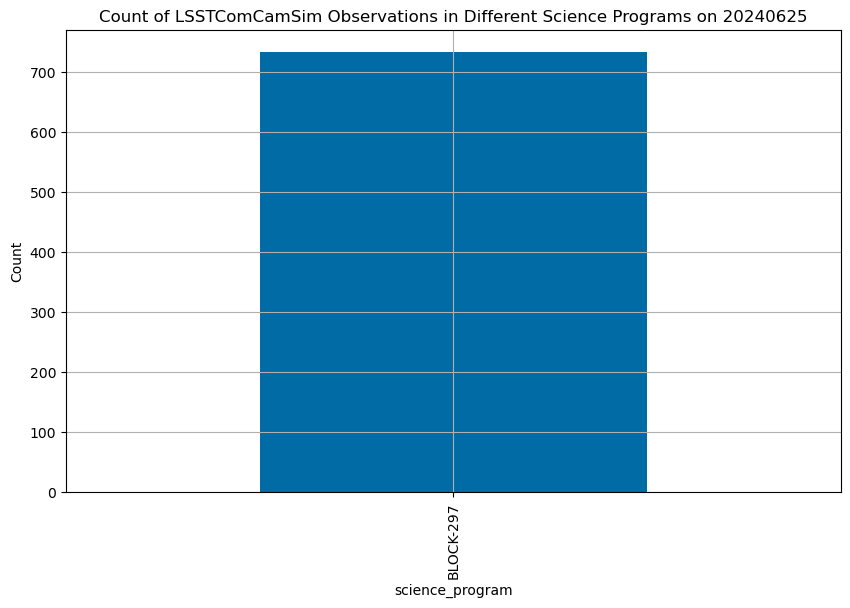

In [42]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
value_counts = df_science[col_sciprog].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel(col_sciprog)
plt.ylabel('Count')
title = "Count of %s Observations in Different Science Programs on %s" % (instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.1.3 Targets

Now, let's look at the counts of exposures for the different targets observed on this date.

In [43]:
df_science.groupby(col_target).count()[col_id]

field_name
DEEP_A0              60
DEEP_B0             103
ELAIS_S1             60
Rubin_SV_225_-40     60
Rubin_SV_250_2       60
Rubin_SV_280_-48    180
Rubin_SV_300_-41    210
Name: id, dtype: int64

Let's plot this as a 1D histogram.

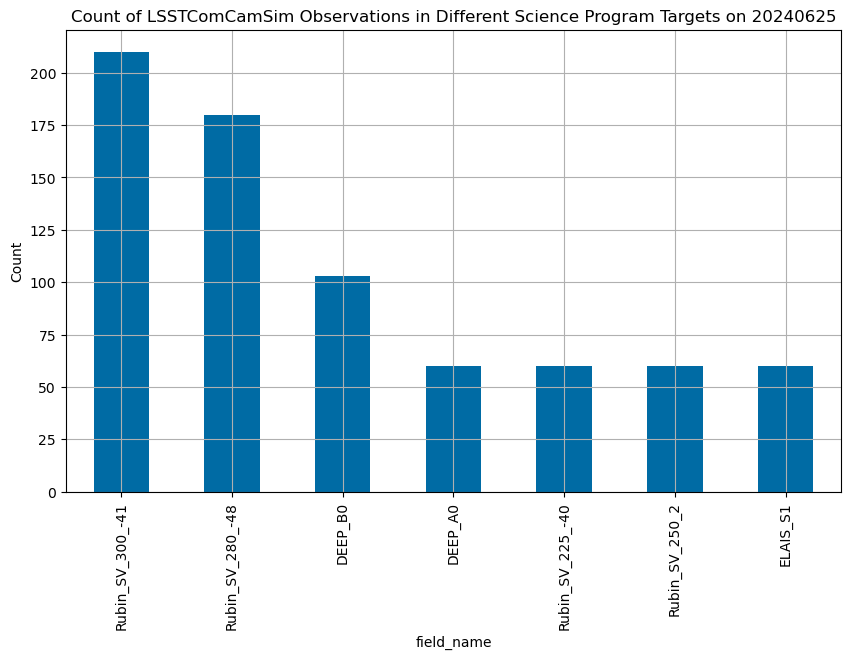

In [44]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
#value_counts = df_science['target'].value_counts()
value_counts = df_science[col_target].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel(col_target)
plt.ylabel('Count')
title = """Count of %s Observations in Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.1.4 Science Program and Target

Let's organize these counts by both **science program** and **target**...

First, we will do a simple `groupby` command, using standard defaults.

In [45]:
df_science.groupby([col_sciprog,col_target]).count()[col_id]

science_program  field_name      
BLOCK-297        DEEP_A0              60
                 DEEP_B0             103
                 ELAIS_S1             60
                 Rubin_SV_225_-40     60
                 Rubin_SV_250_2       60
                 Rubin_SV_280_-48    180
                 Rubin_SV_300_-41    210
Name: id, dtype: int64

We can make this look nicer (and more useful) by converting the results into a pandas DataFrame and outputting the tabular format.  We will make use of the `df2Dgroupby` function defined in Section 1.2.  In this case, we don't care about targets that have a count of 0; so we set the `fill_zeros` parameter to `False`.

In [46]:
df_science_grouped = df2Dgroupby(df_science, col_sciprog, col_target, col_id, False)
df_science_grouped

,science_program,field_name,number
0,BLOCK-297,DEEP_A0,60
1,BLOCK-297,DEEP_B0,103
2,BLOCK-297,ELAIS_S1,60
3,BLOCK-297,Rubin_SV_225_-40,60
4,BLOCK-297,Rubin_SV_250_2,60
5,BLOCK-297,Rubin_SV_280_-48,180
6,BLOCK-297,Rubin_SV_300_-41,210


Let's plot these results as an annotated heatmap:

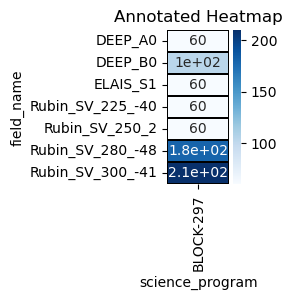

In [47]:
# First, we re-group df_science, setting the `fill_zeros` parameter back to `True`.  
#  This is mostly for aesthetic reasons for the plotting below (the value of '0' 
#  will be included in the annotations for those science_progam/target combos that
#  have no observations); otherwise those boxes will be left blank).
df_science_grouped = df2Dgroupby(df_science, col_sciprog, col_target, col_id, True)

# Now call the plotAnnotatedHeatMap_df2Dgroupby function defined in Section 1.2 above.
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, col_target, col_sciprog, 'number', title='Annotated Heatmap', cmap='Blues')


#### 3.1.5 Target and Filter

Now let's organize these counts by **target** and **filter**...  

In [48]:
df_science.groupby([col_target,col_filter]).count()[col_id]

field_name        filter
DEEP_A0           g_01      20
                  i_06      20
                  r_03      20
DEEP_B0           g_01      40
                  i_06      23
                  r_03      40
ELAIS_S1          g_01      20
                  i_06      20
                  r_03      20
Rubin_SV_225_-40  g_01      20
                  i_06      20
                  r_03      20
Rubin_SV_250_2    g_01      20
                  i_06      20
                  r_03      20
Rubin_SV_280_-48  g_01      60
                  i_06      60
                  r_03      60
Rubin_SV_300_-41  g_01      70
                  i_06      80
                  r_03      60
Name: id, dtype: int64

Again, we can convert the above results into a pandas DataFrame...

In [49]:
df_science_grouped = df2Dgroupby(df_science, col_target, col_filter, col_id, False)
df_science_grouped

,field_name,filter,number
0,DEEP_A0,g_01,20
1,DEEP_A0,i_06,20
2,DEEP_A0,r_03,20
3,DEEP_B0,g_01,40
4,DEEP_B0,i_06,23
5,DEEP_B0,r_03,40
6,ELAIS_S1,g_01,20
7,ELAIS_S1,i_06,20
8,ELAIS_S1,r_03,20
9,Rubin_SV_225_-40,g_01,20


Here's the annotated heatmap of the same...

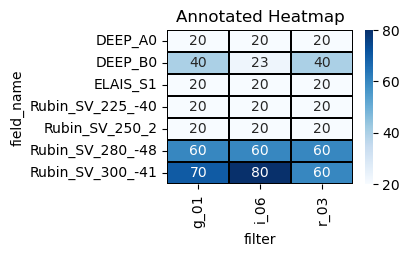

In [50]:
df_science_grouped = df2Dgroupby(df_science, col_target, col_filter, col_id, True)
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, col_target, col_filter, 'number', title='Annotated Heatmap', cmap='Blues')

#### 3.1.6 Science Program, Target, and Filter

Next, let's organize the counts by three variables: **science program**, **target**, and **filter**...  

In [51]:
df_science.groupby([col_sciprog,col_target,col_filter]).count()[col_id]

science_program  field_name        filter
BLOCK-297        DEEP_A0           g_01      20
                                   i_06      20
                                   r_03      20
                 DEEP_B0           g_01      40
                                   i_06      23
                                   r_03      40
                 ELAIS_S1          g_01      20
                                   i_06      20
                                   r_03      20
                 Rubin_SV_225_-40  g_01      20
                                   i_06      20
                                   r_03      20
                 Rubin_SV_250_2    g_01      20
                                   i_06      20
                                   r_03      20
                 Rubin_SV_280_-48  g_01      60
                                   i_06      60
                                   r_03      60
                 Rubin_SV_300_-41  g_01      70
                                   i_06      8

Convert this result into a pandas DataFrame using the `df3groupby` function defined in Section 1.2 above and display the resulting table:

In [52]:
df_science_grouped = df3Dgroupby(df_science, col_sciprog, col_target, col_filter, col_id, False)
df_science_grouped

,science_program,field_name,filter,number
0,BLOCK-297,DEEP_A0,g_01,20
1,BLOCK-297,DEEP_A0,i_06,20
2,BLOCK-297,DEEP_A0,r_03,20
3,BLOCK-297,DEEP_B0,g_01,40
4,BLOCK-297,DEEP_B0,i_06,23
5,BLOCK-297,DEEP_B0,r_03,40
6,BLOCK-297,ELAIS_S1,g_01,20
7,BLOCK-297,ELAIS_S1,i_06,20
8,BLOCK-297,ELAIS_S1,r_03,20
9,BLOCK-297,Rubin_SV_225_-40,g_01,20


#### 3.1.7 Tracts

Now, let's look at the counts of exposures for the different tracts observed on this date.

In [53]:
df_science.groupby('tract').count()[col_id]

tract
2494     43
2495    137
2877     60
3346      3
3384    210
3533     57
6568    103
7445     60
9880     60
Name: id, dtype: int64

Let's plot this as a 1D histogram.

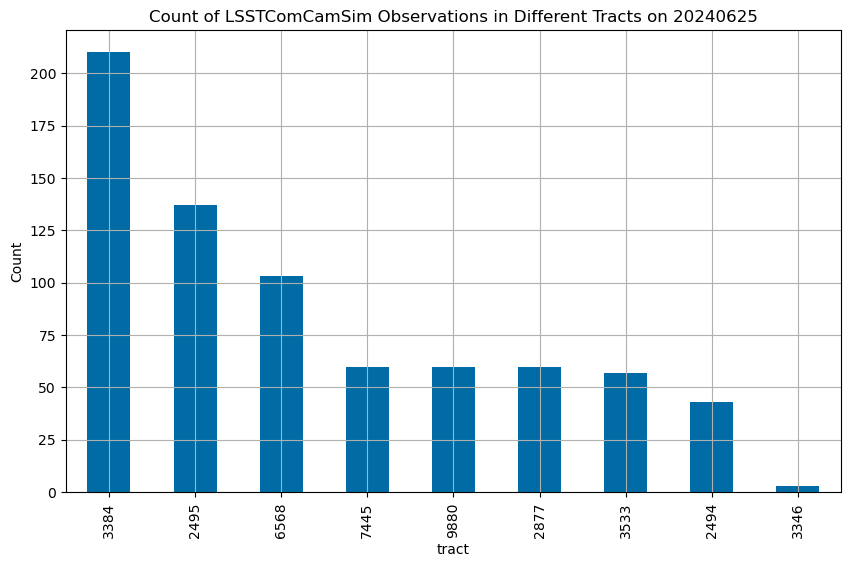

In [54]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each unique value in col1
value_counts = df_science['tract'].value_counts()

# Create the bar plot
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('tract')
plt.ylabel('Count')
title = """Count of %s Observations in Different Tracts on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.1.8 Science Program and Tract

Let's organize these counts by both **science program** and **tract?**...

First, we will do a simple `groupby` command, using standard defaults.

In [55]:
df_science.groupby([col_sciprog,'tract']).count()[col_id]

science_program  tract
BLOCK-297        2494      43
                 2495     137
                 2877      60
                 3346       3
                 3384     210
                 3533      57
                 6568     103
                 7445      60
                 9880      60
Name: id, dtype: int64

We can make this look nicer (and more useful) by converting the results into a pandas DataFrame and outputting the tabular format, again using the `df2Dgroupby` function. 

In [56]:
df_science_grouped = df2Dgroupby(df_science, col_sciprog, 'tract', col_id, False)
df_science_grouped

,science_program,tract,number
0,BLOCK-297,2494,43
1,BLOCK-297,2495,137
2,BLOCK-297,2877,60
3,BLOCK-297,3346,3
4,BLOCK-297,3384,210
5,BLOCK-297,3533,57
6,BLOCK-297,6568,103
7,BLOCK-297,7445,60
8,BLOCK-297,9880,60


Let's plot these results as an annotated heatmap:

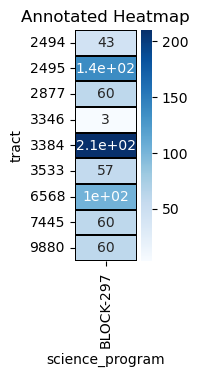

In [57]:
# First, we re-group df_science, setting the `fill_zeros` parameter back to `True`.  
#  This is mostly for aesthetic reasons for the plotting below (the value of '0' 
#  will be included in the annotations for those science_progam/target combos that
#  have no observations); otherwise those boxes will be left blank).
df_science_grouped = df2Dgroupby(df_science, col_sciprog, 'tract', col_id, True)

# Now call the plotAnnotatedHeatMap_df2Dgroupby function defined in Section 1.2 above.
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, 'tract', col_sciprog, 'number', title='Annotated Heatmap', cmap='Blues')


#### 3.1.9 Tract and Filter

Now let's organize these counts by **tract** and **filter**...  

In [58]:
df_science.groupby(['tract',col_filter]).count()[col_id]

tract  filter
2494   g_01      16
       i_06      13
       r_03      14
2495   g_01      44
       i_06      47
       r_03      46
2877   g_01      20
       i_06      20
       r_03      20
3346   g_01       2
       i_06       1
3384   g_01      70
       i_06      80
       r_03      60
3533   g_01      18
       i_06      19
       r_03      20
6568   g_01      40
       i_06      23
       r_03      40
7445   g_01      20
       i_06      20
       r_03      20
9880   g_01      20
       i_06      20
       r_03      20
Name: id, dtype: int64

Again, we can convert the above results into a pandas DataFrame...

In [59]:
df_science_grouped = df2Dgroupby(df_science, 'tract', col_filter, col_id, False)
df_science_grouped

,tract,filter,number
0,2494,g_01,16
1,2494,i_06,13
2,2494,r_03,14
3,2495,g_01,44
4,2495,i_06,47
5,2495,r_03,46
6,2877,g_01,20
7,2877,i_06,20
8,2877,r_03,20
9,3346,g_01,2


Here's the annotated heatmap of the same...

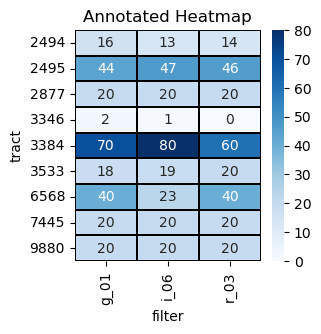

In [60]:
df_science_grouped = df2Dgroupby(df_science, 'tract', col_filter, col_id, True)
plotAnnotatedHeatMap_df2Dgroupby(df_science_grouped, 'tract', col_filter, 'number', title='Annotated Heatmap', cmap='Blues')

#### 3.1.10 Science Program, Tract, and Filter

Next, let's organize the counts by three variables: **science program**, **tract**, and **filter**...  

In [61]:
df_science.groupby([col_sciprog,'tract',col_filter]).count()[col_id]

science_program  tract  filter
BLOCK-297        2494   g_01      16
                        i_06      13
                        r_03      14
                 2495   g_01      44
                        i_06      47
                        r_03      46
                 2877   g_01      20
                        i_06      20
                        r_03      20
                 3346   g_01       2
                        i_06       1
                 3384   g_01      70
                        i_06      80
                        r_03      60
                 3533   g_01      18
                        i_06      19
                        r_03      20
                 6568   g_01      40
                        i_06      23
                        r_03      40
                 7445   g_01      20
                        i_06      20
                        r_03      20
                 9880   g_01      20
                        i_06      20
                        r_03      20
Name: i

Convert this result into a pandas DataFrame using the `df3groupby` function and display the resulting table:

In [62]:
df_science_grouped = df3Dgroupby(df_science, col_sciprog, 'tract', col_filter, col_id, False)
df_science_grouped

,science_program,tract,filter,number
0,BLOCK-297,2494,g_01,16
1,BLOCK-297,2494,i_06,13
2,BLOCK-297,2494,r_03,14
3,BLOCK-297,2495,g_01,44
4,BLOCK-297,2495,i_06,47
5,BLOCK-297,2495,r_03,46
6,BLOCK-297,2877,g_01,20
7,BLOCK-297,2877,i_06,20
8,BLOCK-297,2877,r_03,20
9,BLOCK-297,3346,g_01,2


### 3.2 Positions

#### 3.2.1 Target RA, DEC

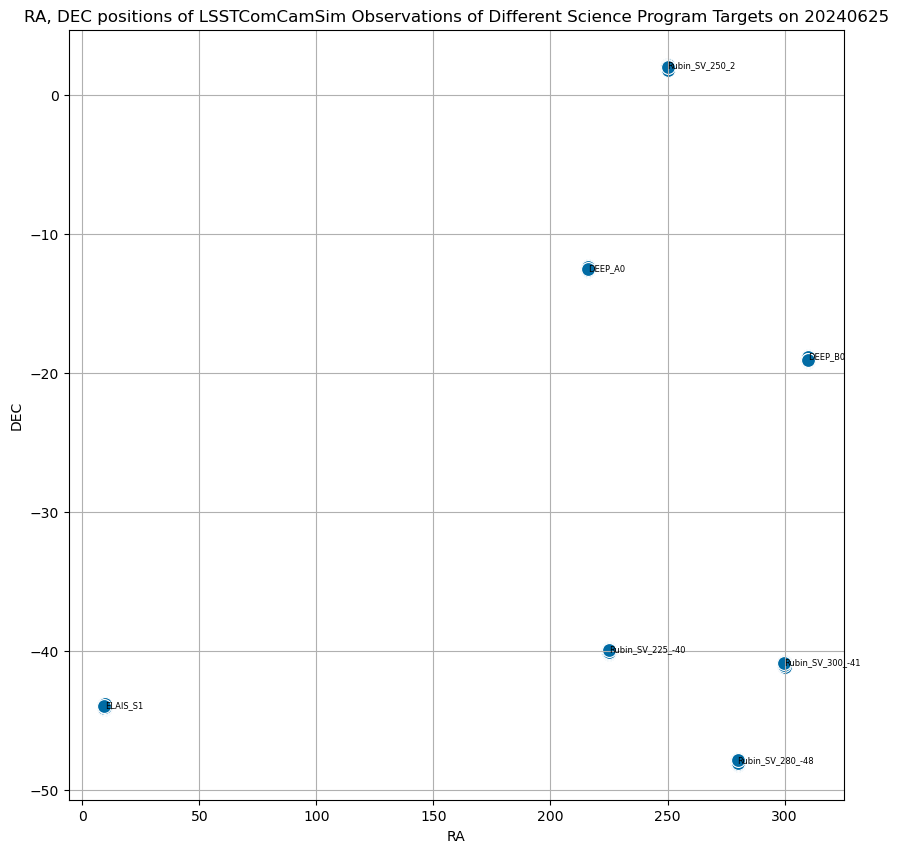

In [63]:
df_science.sort_values(by='field_name', inplace=True)

plt.figure(figsize=(10, 10))

# Plot in Cartesian coordinates
if df_science[col_target].dtype == "int64" or df_science[col_target].dtype == "float64":
    # We create and annotate the plot one way if col_target is numerical...
    ax = sns.scatterplot(data=df_science, x="ra", y="dec", hue=col_target, palette='viridis', s=100)
else:
    # Otherwise, if col_target is a string or similar, we create and annotate the plot this way...
    #  (This could be done better.  As it is, the spacing is very crowded.)
    ax = sns.scatterplot(data=df_science, x="ra", y="dec", s=100)
    prev_label = 'XXXXXX'
    for i, label in enumerate(df_science[col_target]):
        if label != prev_label:
            ax.annotate(label, (df_science['ra'].iloc[i], df_science['dec'].iloc[i]), fontsize=6)
            prev_label = label

# Add labels and title
plt.xlabel('RA')
plt.ylabel('DEC')
title = """RA, DEC positions of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)

#### 3.2.2 Target vs. zenith_angle

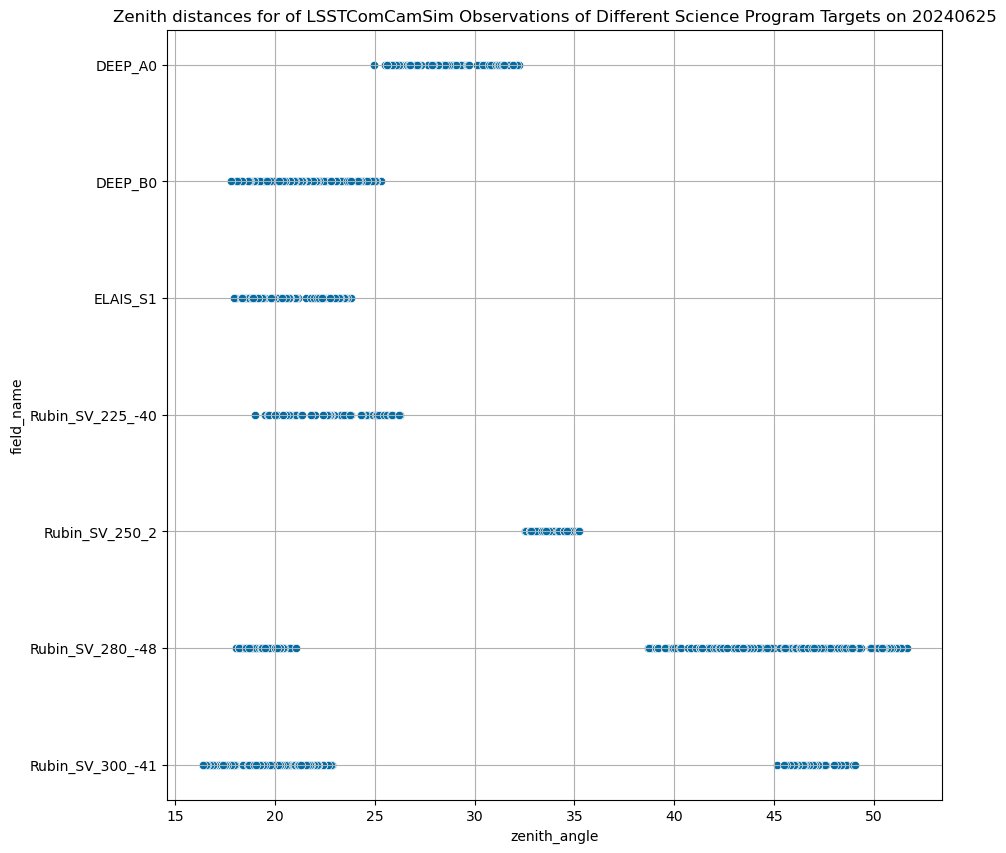

In [64]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="zenith_angle", y=col_target)

# Add labels and title
#plt.xlabel('Zenith Angle')
#plt.ylabel('Target')
title = """Zenith distances for of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.2.3 Target vs. MJD

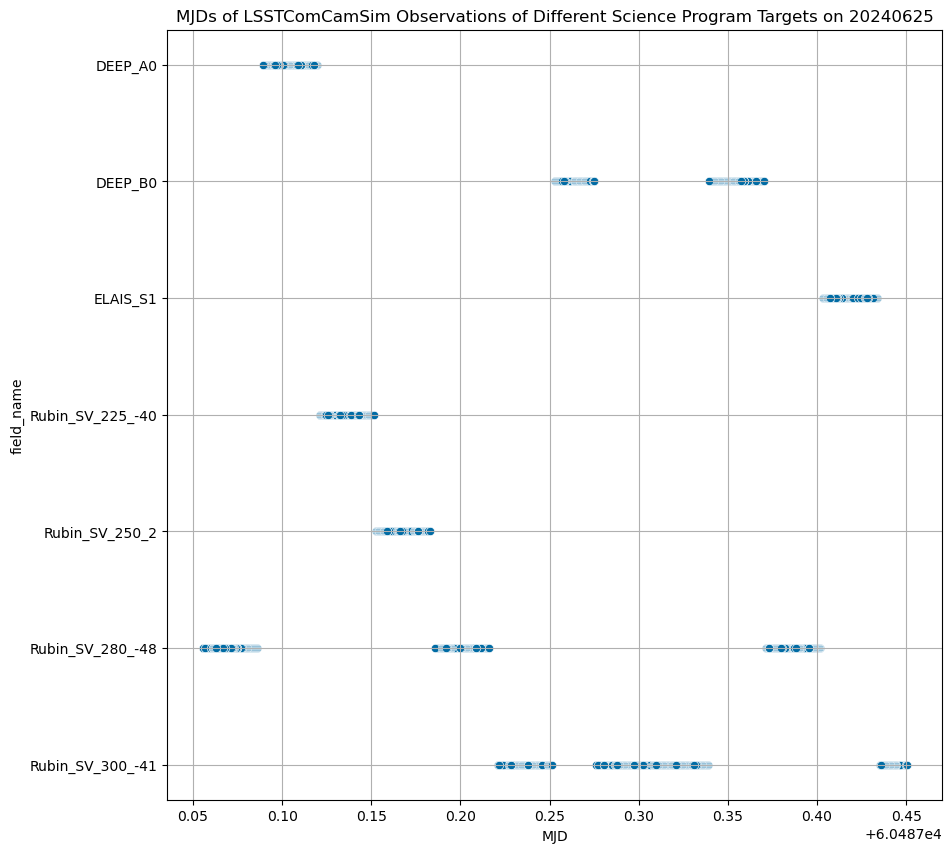

In [65]:
plt.figure(figsize=(10, 10))

#ax = sns.scatterplot(data=df_science, x="mjd", y="target")
ax = sns.scatterplot(data=df_science, x="mjd", y=col_target)


# Add labels and title
plt.xlabel('MJD')
plt.ylabel(col_target)
title = """MJDs of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.2.4 Target zenith angle vs. MJD

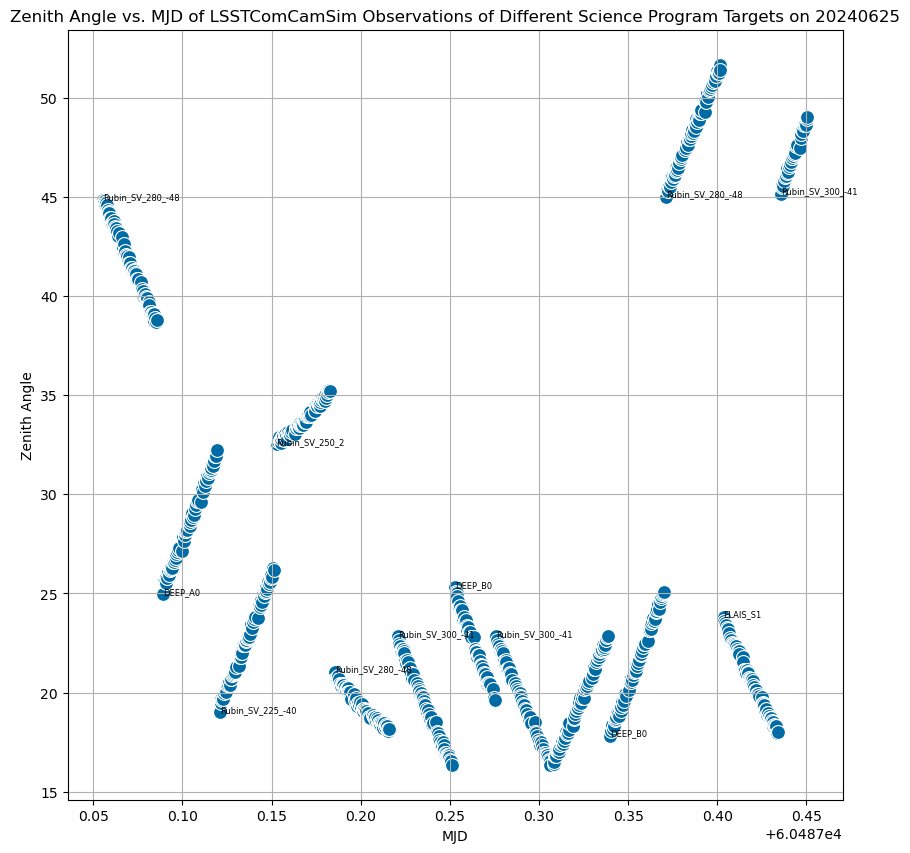

In [66]:
df_science.sort_values(by='mjd', inplace=True)

plt.figure(figsize=(10, 10))

# Plot in Cartesian coordinates
if df_science[col_target].dtype == "int64" or df_science[col_target].dtype == "float64":
    # We create and annotate the plot one way if col_target is numerical...
    ax = sns.scatterplot(data=df_science, x="mjd", y="zenith_angle", hue=col_target, palette='viridis', s=100)
else:
    # Otherwise, if col_target is a string or similar, we create and annotate the plot this way...
    #  (This could be done better.  As it is, the spacing is very crowded.)
    ax = sns.scatterplot(data=df_science, x="mjd", y="zenith_angle", s=100)
    prev_label = 'XXXXXX'
    for i, label in enumerate(df_science[col_target]):
        if label != prev_label:
            #mjd = df_science['mjd'].iloc[i]
            #za = df_science['zenith_angle'].iloc[i]
            #print(i, label, mjd, za)
            ax.annotate(label, (df_science['mjd'].iloc[i], df_science['zenith_angle'].iloc[i]), fontsize=6)
            prev_label = label

# Add labels and title
plt.xlabel('MJD')
plt.ylabel('Zenith Angle')
title = """Zenith Angle vs. MJD of %s Observations of Different Science Program Targets on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)

#### 3.2.5 Tract RA, DEC

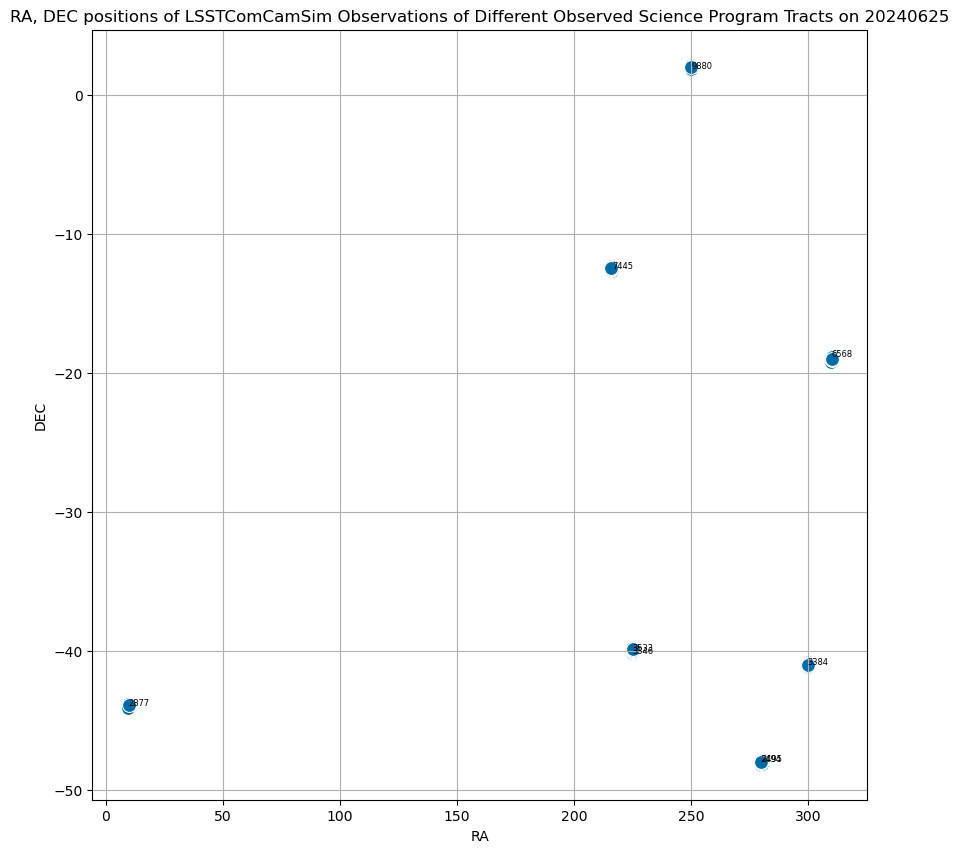

In [67]:
df_science.sort_values(by='tract', inplace=True)

plt.figure(figsize=(10, 10))

# Plot in Cartesian coordinates
ax = sns.scatterplot(data=df_science, x="ra", y="dec", s=100)
prev_label = -9999
for i, label in enumerate(df_science['tract']):
    if label != prev_label:
        ax.annotate(label, (df_science['ra'].iloc[i], df_science['dec'].iloc[i]), fontsize=6)
        prev_label = label

# Add labels and title
plt.xlabel('RA')
plt.ylabel('DEC')
title = """RA, DEC positions of %s Observations of Different Observed Science Program Tracts on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)

#### 3.2.6 Tract vs. zenith_angle

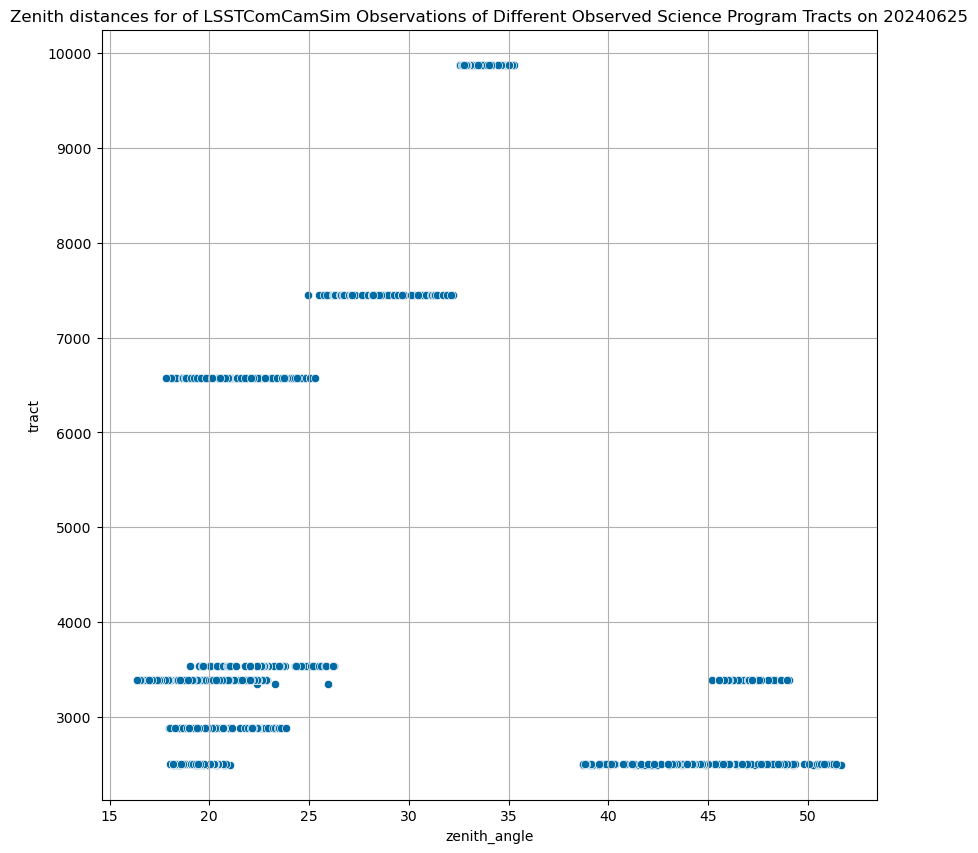

In [68]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="zenith_angle", y='tract')

# Add labels and title
title = """Zenith distances for of %s Observations of Different Observed Science Program Tracts on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.2.7 Tract vs. MJD

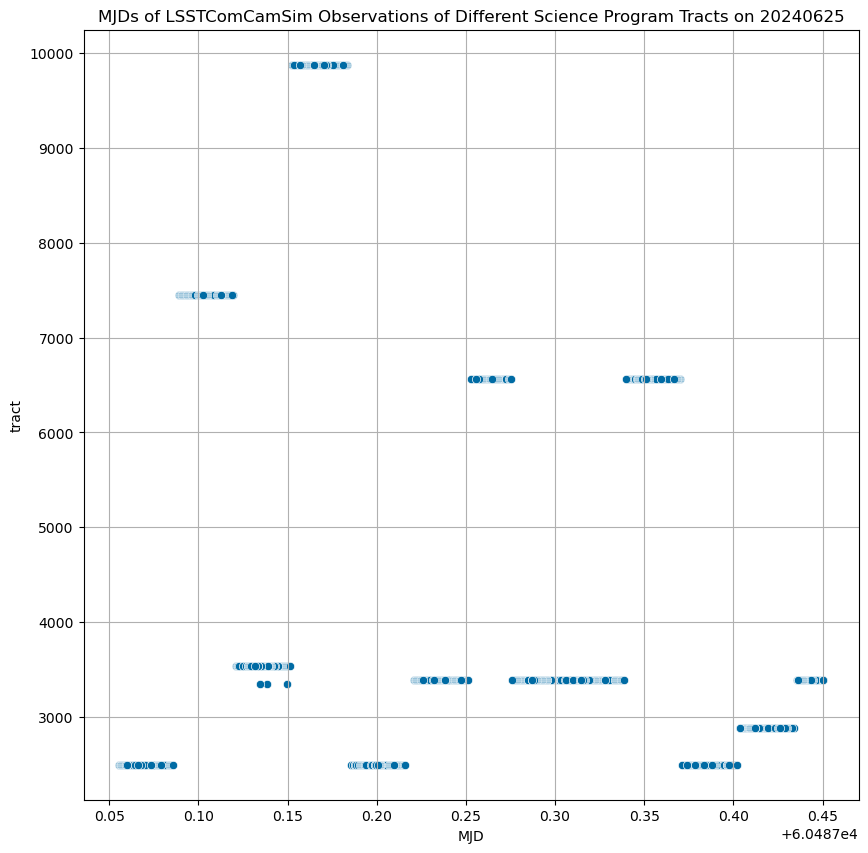

In [69]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(data=df_science, x="mjd", y='tract')

# Add labels and title
plt.xlabel('MJD')
plt.ylabel('tract')
title = """MJDs of %s Observations of Different Science Program Tracts on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)


#### 3.2.8 Tract zenith angle vs. MJD

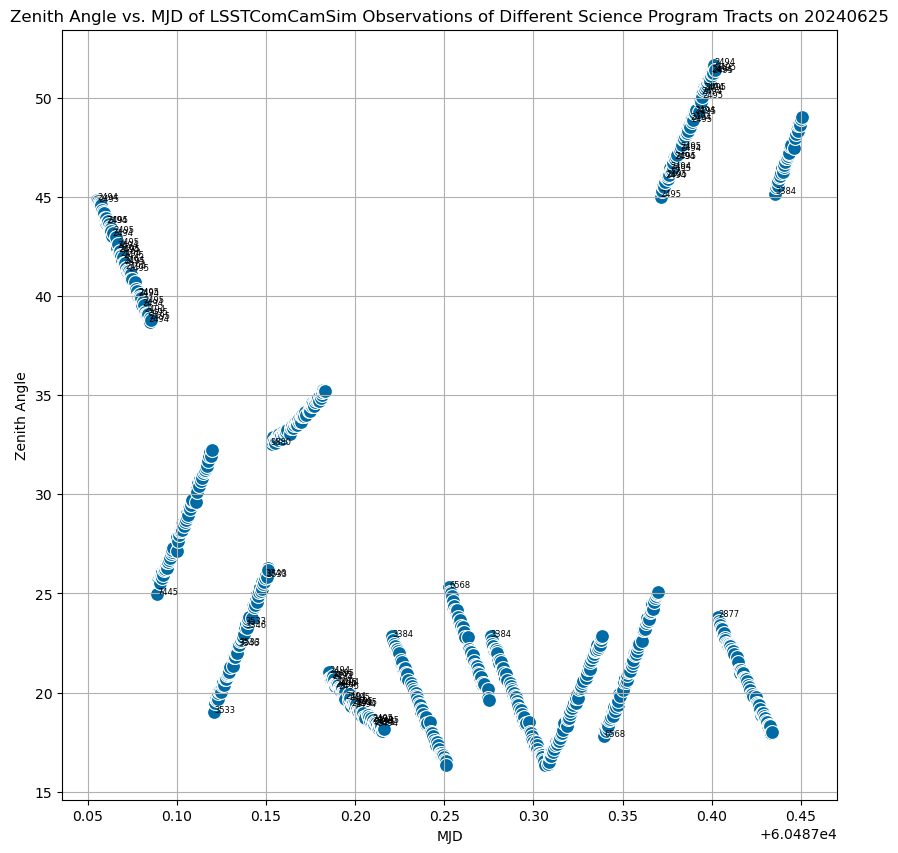

In [70]:
df_science.sort_values(by='mjd', inplace=True)

plt.figure(figsize=(10, 10))

# Plot in Cartesian coordinates
ax = sns.scatterplot(data=df_science, x="mjd", y="zenith_angle", s=100)
prev_label = -9999
for i, label in enumerate(df_science['tract']):
    if label != prev_label:
        ax.annotate(label, (df_science['mjd'].iloc[i], df_science['zenith_angle'].iloc[i]), fontsize=6)
        prev_label = label

# Add labels and title
plt.xlabel('MJD')
plt.ylabel('Zenith Angle')
title = """Zenith Angle vs. MJD of %s Observations of Different Science Program Tracts on %s""" %(instrument, day_obs)
plt.title(title)
plt.grid(True)

## 4. Final cleanup

Reset the pandas maximum rows option it its original default.

In [71]:
# Reset the display.max_rows option to the original default
pd.reset_option("display.max_rows")

In [72]:
# Stop automatic execution of cells before reaching the Sandbox...
sys.exit("Notebook execution stopped here.")

SystemExit: Notebook execution stopped here.

## 5. Sandbox

### 5.1 Working with Butler queries

In [73]:
for c in sorted(registry.queryCollections("*LSSTComCamSim/quickLook/24*")):
    print(c)

In [74]:
dt = registry.getDatasetType('preVisitTable')
print("Name:", dt.name)
print("Dimensions:", dt.dimensions)
print("Storage Class:", dt.storageClass)

Name: preVisitTable
Dimensions: {instrument}
Storage Class: DataFrame


In [75]:
datasetType = 'preVisitTable'
dataId = {'instrument': instrument}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId, collections=collection)

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    #print("band:", ref.dataId['band'])

{instrument: 'LSSTComCamSim'}


In [76]:
dataId = {'instrument': instrument}
preVisitTable = butler.get('preVisitTable', dataId=dataId)
preVisitTable

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
7024061800022,7024061800022,g_01,g,250.103216,2.046445,2.046445,180.439815,57.671037,39.532375,50.467625,1.571057,30.0,2024-06-19 00:22:53.175492,60480.015893,2024-06-19 00:22:38.175492,60480.01572


In [77]:
visits = list(butler.registry.queryDatasets('visitSummary'))

In [78]:
# Print out first 5 visits in list...
visits[:5]

[DatasetRef(DatasetType('visitSummary', {band, instrument, day_obs, physical_filter, visit}, ExposureCatalog), {instrument: 'LSSTComCamSim', visit: 7024061800022, band: 'g', day_obs: 20240618, physical_filter: 'g_01'}, run='LSSTComCamSim/nightlyValidation/0', id=179e93e5-bb52-4825-b5b9-c5c9f0244123),
 DatasetRef(DatasetType('visitSummary', {band, instrument, day_obs, physical_filter, visit}, ExposureCatalog), {instrument: 'LSSTComCamSim', visit: 7024061800042, band: 'i', day_obs: 20240618, physical_filter: 'i_06'}, run='LSSTComCamSim/nightlyValidation/0', id=bf598c4f-12d5-43b8-88f5-5b94faaea056),
 DatasetRef(DatasetType('visitSummary', {band, instrument, day_obs, physical_filter, visit}, ExposureCatalog), {instrument: 'LSSTComCamSim', visit: 7024061800075, band: 'i', day_obs: 20240618, physical_filter: 'i_06'}, run='LSSTComCamSim/nightlyValidation/0', id=abdf2266-2e52-48bf-b10b-c40ec1ed1540)]

In [79]:
# This failed due to difficulties identifying the correct dataId designation.

#datasetType = 'visitTable'
##dataId = {'instrument': instrument}
#dataId = {'day_obs': day_obs}

#visitSummary = butler.get(datasetType, dataId=dataId)
##visitSummary = butler.get('visitSummary', {band, instrument, day_obs, physical_filter, visit})

In [80]:
list(butler.registry.queryDatasets('ccdVisitTable'))

[]

In [81]:
list(butler.registry.queryDatasets('visitTable'))

[]

In [82]:
list(butler.registry.queryDatasets('preVisitTable'))

[DatasetRef(DatasetType('preVisitTable', {instrument}, DataFrame), {instrument: 'LSSTComCamSim'}, run='LSSTComCamSim/nightlyValidation/0', id=b77410a0-cb2b-4d87-a9ee-a4b5df926a79)]

In [83]:
for c in sorted(registry.queryCollections("*LSSTComCamSim/runs/nightlyValidation/*/*/DM-44966")):
    print(c)

LSSTComCamSim/runs/nightlyValidation/20240625/w_2024_25/DM-44966
LSSTComCamSim/runs/nightlyValidation/20240626/w_2024_25/DM-44966
LSSTComCamSim/runs/nightlyValidation/20240627/w_2024_25/DM-44966
LSSTComCamSim/runs/nightlyValidation/pretest1/w_2024_25/DM-44966
LSSTComCamSim/runs/nightlyValidation/pretest3/w_2024_25/DM-44966
LSSTComCamSim/runs/nightlyValidation/pretest3ssq2/w_2024_25/DM-44966
LSSTComCamSim/runs/nightlyValidation/test1a/d_2024_06_21/DM-44966
LSSTComCamSim/runs/nightlyValidation/test1a/w_2024_25/DM-44966
LSSTComCamSim/runs/nightlyValidation/test1b/d_2024_06_21/DM-44966


In [84]:
print(butler.dimensions.getStaticDimensions())

{band, healpix1, healpix2, healpix3, healpix4, healpix5, healpix6, healpix7, healpix8, healpix9, healpix10, healpix11, healpix12, healpix13, healpix14, healpix15, healpix16, healpix17, htm1, htm2, htm3, htm4, htm5, htm6, htm7, htm8, htm9, htm10, htm11, htm12, htm13, htm14, htm15, htm16, htm17, htm18, htm19, htm20, htm21, htm22, htm23, htm24, instrument, skymap, day_obs, detector, group, physical_filter, subfilter, tract, visit_system, exposure, patch, visit}


In [85]:
print(butler.dimensions["skymap"].RecordClass.fields)

skymap: 
  name: str
  hash: bytes
  tract_max: int
  patch_nx_max: int
  patch_ny_max: int


In [86]:
query="instrument='%s' AND day_obs=%d" % (instrument, day_obs)
results = registry.queryDimensionRecords('skymap',where=query)
results.count()

5

In [87]:
for count, info in enumerate(results):
    print(count, info)
    print('')

0 skymap:
  name: 'DC2_cells_v1'
  hash: b'\x14\xffq765%x\xcf\x01\xb5\xda\xe4b\xf5&$[\xb5\x16'
  tract_max: 18938
  patch_nx_max: 10
  patch_ny_max: 10

1 skymap:
  name: 'hsc_rings_v1'
  hash: b'\xe2\x9f\xe9\xf1\x00\x8e5\x9f6\xa3g~}i\xccC\x93v\xd1\xe6'
  tract_max: 18938
  patch_nx_max: 9
  patch_ny_max: 9

2 skymap:
  name: 'latiss_v1'
  hash: b'e~\xde\x8a\xcc6\xcd\x11\xfc\x11b\x02{r\xeeM\x1b\x92\x99\xbc'
  tract_max: 18938
  patch_nx_max: 19
  patch_ny_max: 19

3 skymap:
  name: 'lsst_cells_v1'
  hash: b'\xe2snA$M\xf0\x0b\xbd\xb9:\xec\xac\n\xe4\xb2\xd1\x9d\xda\x91'
  tract_max: 18938
  patch_nx_max: 10
  patch_ny_max: 10

4 skymap:
  name: 'ops_rehersal_prep_2k_v1'
  hash: b'\xe9F\x11\xf9O\x88\xb0mA\xd3\xd7\x19\xc9L\xda\x9aK3\x97\x84'
  tract_max: 18938
  patch_nx_max: 17
  patch_ny_max: 17



### 5.2 Working with the EFD

(Based on material from `ops_rehearsal_comcam_analysis.ipynb`)

<span style="color:red; font-weight:bold">Not much luck just yet using the EFD data.  Mostly just flailing around.  </span>


In [88]:
from lsst_efd_client import EfdClient
client = EfdClient("usdfdev_efd", db_name="lsst.dm")

In [89]:
topics = await client.get_topics()
for t in topics: print(t)

lsst.dm.NumDiaSources
lsst.dm.NumStreakCenterDiaSources
lsst.dm.NumStreakDiaSources
lsst.dm.ap12PsfSky
lsst.dm.astromColorDiffMetrics
lsst.dm.astromDiffMetrics
lsst.dm.blendMetrics
lsst.dm.calexpMetrics
lsst.dm.calexpSummaryMetrics
lsst.dm.calibrate
lsst.dm.coaddInputCount
lsst.dm.constantTool
lsst.dm.diaSourcesGoodVsBadRatio
lsst.dm.diffimMetadataMetric
lsst.dm.e1Diff
lsst.dm.e1DiffScatterMetric
lsst.dm.e2Diff
lsst.dm.e2DiffScatterMetric
lsst.dm.isolatedDeblenderMetrics
lsst.dm.matchedRefAngularSeparationChi
lsst.dm.matchedRefAngularSeparationDiff
lsst.dm.matchedRefCModelColorChi
lsst.dm.matchedRefCModelColorDiff
lsst.dm.matchedRefCModelFluxChiMetric
lsst.dm.matchedRefCModelMagChi
lsst.dm.matchedRefCModelMagDiff
lsst.dm.matchedRefCModelMagDiffMetric
lsst.dm.matchedRefMagChiMetric
lsst.dm.matchedRefPositionDecChi
lsst.dm.matchedRefPositionDecDiff
lsst.dm.matchedRefPositionRaChi
lsst.dm.matchedRefPositionRaDiff
lsst.dm.matchedRefPositionXChi
lsst.dm.matchedRefPositionXChiMetric
lsst.dm.

In [90]:
#query = '''SELECT * FROM "lsst.dm.e1Diff" WHERE time > now() - 100d '''
#query = '''SELECT * FROM "lsst.dm.calexpMetrics" WHERE time > now() - 100d'''
#query = '''SELECT instrument FROM "lsst.dm.calexpMetrics" WHERE (time > now() - 100d)'''
query = """SELECT * FROM "lsst.dm.calexpMetrics" WHERE instrument='LSSTComCamSim' and (time > now() - 100d)"""
#query = 'SELECT * FROM "lsst.dm.psfSigma"'

#query = '''SELECT DISTINCT day_obs FROM "lsst.dm.calexpMetrics"'''
df = await client.influx_client.query(query)
#df.columns.values
#df.iloc[0]
df

,astromOffsetMean,astromOffsetStd,band,band_1,dataset_tag,dataset_tag_1,dataset_type,day_obs,dec,detector,...,run_timestamp,skyBg,skyNoise,skymap,timestamp,tract,visit,visit_1,zenithDistance,zeroPoint
2024-04-01 23:04:49+00:00,0.007535,0.004387,r,r,Generic,Generic,calexpSummary_metrics,,-14.898025,1,...,1712012689,621.163452,21.164419,,1712012689,,7024040100020,7024040100020,47.817162,31.234436
2024-04-01 23:39:17+00:00,0.007535,0.004387,r,r,LSSTComCamSim/test_ctslater,LSSTComCamSim/test_ctslater,calexpSummary_metrics,,-14.898025,1,...,1712014757,621.163452,21.164419,,1712014757,,7024040100020,7024040100020,47.817162,31.234436
2024-04-02 00:03:29+00:00,0.006874,0.003926,r,r,LSSTComCamSim/test_ctslater,LSSTComCamSim/test_ctslater,calexpSummary_metrics,,-14.665673,2,...,1712016209,634.398071,22.057919,,1712016209,,7024040100020,7024040100020,47.955143,31.255642


In [91]:
# Always set a time range!!!
for t in topics:
    query = '''SELECT * FROM "%s"''' % t
    print(query)
    df = await client.influx_client.query(query)
    print(df.size)

SELECT * FROM "lsst.dm.NumDiaSources"
3700
SELECT * FROM "lsst.dm.NumStreakCenterDiaSources"
3700
SELECT * FROM "lsst.dm.NumStreakDiaSources"
3700
SELECT * FROM "lsst.dm.ap12PsfSky"
8721
SELECT * FROM "lsst.dm.astromColorDiffMetrics"
116704
SELECT * FROM "lsst.dm.astromDiffMetrics"
4412450
SELECT * FROM "lsst.dm.blendMetrics"
10152
SELECT * FROM "lsst.dm.calexpMetrics"
17985
SELECT * FROM "lsst.dm.calexpSummaryMetrics"
2343720
SELECT * FROM "lsst.dm.calibrate"
156
SELECT * FROM "lsst.dm.coaddInputCount"
3354
SELECT * FROM "lsst.dm.constantTool"
270
SELECT * FROM "lsst.dm.diaSourcesGoodVsBadRatio"
3744
SELECT * FROM "lsst.dm.diffimMetadataMetric"
304480
SELECT * FROM "lsst.dm.e1Diff"
39120
SELECT * FROM "lsst.dm.e1DiffScatterMetric"
812
SELECT * FROM "lsst.dm.e2Diff"
39120
SELECT * FROM "lsst.dm.e2DiffScatterMetric"
812
SELECT * FROM "lsst.dm.isolatedDeblenderMetrics"
10152
SELECT * FROM "lsst.dm.matchedRefAngularSeparationChi"
9600
SELECT * FROM "lsst.dm.matchedRefAngularSeparationDiff

In [92]:
for t in topics:
    query = '''SELECT DISTINCT instrument FROM "%s"''' % t
    print(query)
    df = await client.influx_client.query(query)
    print(df)

SELECT DISTINCT instrument FROM "lsst.dm.NumDiaSources"
  distinct
0         
SELECT DISTINCT instrument FROM "lsst.dm.NumStreakCenterDiaSources"
  distinct
0         
SELECT DISTINCT instrument FROM "lsst.dm.NumStreakDiaSources"
  distinct
0         
SELECT DISTINCT instrument FROM "lsst.dm.ap12PsfSky"
  distinct
0         
SELECT DISTINCT instrument FROM "lsst.dm.astromColorDiffMetrics"
        distinct
0            HSC
1  LSSTCam-imSim
SELECT DISTINCT instrument FROM "lsst.dm.astromDiffMetrics"
        distinct
0               
1            HSC
2  LSSTComCamSim
3  LSSTCam-imSim
SELECT DISTINCT instrument FROM "lsst.dm.blendMetrics"
  distinct
0         
SELECT DISTINCT instrument FROM "lsst.dm.calexpMetrics"
        distinct
0            HSC
1  LSSTComCamSim
SELECT DISTINCT instrument FROM "lsst.dm.calexpSummaryMetrics"
        distinct
0            HSC
1  LSSTComCamSim
SELECT DISTINCT instrument FROM "lsst.dm.calibrate"
  distinct
0      HSC
SELECT DISTINCT instrument FROM "lsst.dm

In [93]:
query = '''SELECT * FROM "lsst.dm.calexpSummaryMetrics"'''
print(query)
df = await client.influx_client.query(query)
sdf = df[(df.instrument=="LSSTComCamSim")]


SELECT * FROM "lsst.dm.calexpSummaryMetrics"


In [94]:
sdf.iloc[0]

astromOffsetMean                                                 0.007929
astromOffsetStd                                                  0.004072
band                                                                    i
band_1                                                                  i
dataset_tag                                                      DM_43439
dataset_tag_1                                                    DM_43439
dataset_type                                        calexpSummary_metrics
day_obs                                                                  
dec                                                            -15.502588
detector                                                                0
detector_1                                                              0
effTime                                                         43.204258
effTimePsfSigmaScale                                             0.549338
effTimeSkyBgScale                     

In [95]:
df_exposure.iloc[0]

id                              7024062500033
obs_id                   CC_S_20240625_000033
day_obs                              20240625
seq_num                                    33
time_start         2024-06-25 22:15:21.649987
time_end           2024-06-25 22:15:38.729000
type                                     flat
reason                                   flat
target                                UNKNOWN
filter                                   i_06
zenith_angle                              NaN
expos                                    15.0
ra                                        0.0
dec                                       0.0
skyangle                                  NaN
azimuth                                   NaN
zenith                                    NaN
science_program                       unknown
jd                             2460487.427334
mjd                              60486.927334
HPX64                                   19456
HPX16                             

In [96]:
query = '''SELECT DISTINCT instrument FROM "lsst.dm.psfSigma"'''
print(query)
df = await client.influx_client.query(query)
df


SELECT DISTINCT instrument FROM "lsst.dm.psfSigma"


,distinct
0,HSC


### 5.3 Working with the new Consolidated database (ConsDB)

On 21 June 2024, I ran into Eric Neilsen in the hallway, and he pointed me to the new ConsDB!  Here are my first attempts to work with it.  Eric pointed me to the documentation for the consolidated database is (https://confluence.lsstcorp.org/pages/viewpage.action?pageId=264472256) and to the `#rubinobs-consolidated-database` Slack channel, both of which were extremely useful.

Let's try out some things...

In [97]:
os.environ["no_proxy"]

'hub.nublado,.sdf.slac.stanford.edu,.slac.stanford.edu,localhost,127.0.0.1'

In [98]:
os.environ["no_proxy"] += ",.consdb"

In [99]:
os.environ["no_proxy"]

'hub.nublado,.sdf.slac.stanford.edu,.slac.stanford.edu,localhost,127.0.0.1,.consdb'

In [100]:
from lsst.summit.utils import ConsDbClient

In [101]:
client = ConsDbClient(f"http://consdb-pq.consdb:8080/consdb")

In [102]:
print(client.schema())

['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim']


In [103]:
client.query('SELECT * from cdb_lsstcomcamsim.ccdvisit1_quicklook WHERE ccdvisit_id = 731503416576')

ccdvisit_id,s_ra,s_dec,zenith_distance,photometric_calib,psf_sigma,sky_bg,sky_noise,astrom_offset_mean,astrom_offset_std,n_psf_star,psf_star_delta_e1_median,psf_star_delta_e2_median,psf_star_delta_e1_scatter,psf_star_delta_e2_scatter,psf_star_delta_size_median,psf_star_delta_size_scatter,psf_star_scaled_delta_size_scatter,psf_trace_radius_delta,max_dist_to_nearest_psf,zero_point,seeing_zenith_500nm,mean_var,eff_time,eff_time_psf_sigma_scale,eff_time_sky_bg_scale,eff_time_zero_point_scale,psf_area,psf_ixx,psf_ixy,psf_iyy
int64,object,object,float64,object,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object,object,object,object,object,object,object,object
731503416576,None,None,33.18247177930408,None,4.739946930637062,2425.3551913797855,39.73685790587462,0.013435208726783885,0.013435208726783885,83,-0.00023713745460151746,0.000994816986924097,0.006154216015876155,0.006118414297746918,0.020578201475327518,0.02256738822965238,0.004747210673784769,0.11150700603390895,970.8062026427309,31.315535075389125,None,1595.5523840653523,None,None,None,None,None,None,None,None


In [104]:
client.schema('lsstcomcamsim')

['cdb_lsstcomcamsim.ccdexposure',
 'cdb_lsstcomcamsim.exposure',
 'cdb_lsstcomcamsim.ccdexposure_camera',
 'cdb_lsstcomcamsim.ccdvisit1_quicklook',
 'cdb_lsstcomcamsim.visit1_quicklook',
 'cdb_lsstcomcamsim.exposure_flexdata',
 'cdb_lsstcomcamsim.exposure_flexdata_schema',
 'cdb_lsstcomcamsim.ccdexposure_flexdata',
 'cdb_lsstcomcamsim.ccdexposure_flexdata_schema']

In [105]:
for table_name in client.schema('lsstcomcamsim'):
    print("")
    print(table_name)
    print("====================")
    print(client.schema('lsstcomcamsim',table_name))


cdb_lsstcomcamsim.ccdexposure
{'ccdexposure_id': ('BIGINT', 'None'), 'detector': ('INTEGER', 'None'), 'exposure_id': ('BIGINT', 'None'), 's_region': ('VARCHAR(1024)', 'None')}

cdb_lsstcomcamsim.exposure
{'air_temp': ('DOUBLE PRECISION', 'None'), 'airmass': ('DOUBLE PRECISION', 'None'), 'altitude': ('DOUBLE PRECISION', 'None'), 'altitude_end': ('DOUBLE PRECISION', 'None'), 'altitude_start': ('DOUBLE PRECISION', 'None'), 'azimuth': ('DOUBLE PRECISION', 'None'), 'azimuth_end': ('DOUBLE PRECISION', 'None'), 'azimuth_start': ('DOUBLE PRECISION', 'None'), 'band': ('VARCHAR(32)', 'None'), 'controller': ('VARCHAR(1)', 'None'), 'cur_index': ('INTEGER', 'None'), 'dark_time': ('DOUBLE PRECISION', 'None'), 'day_obs': ('INTEGER', 'None'), 'dimm_seeing': ('DOUBLE PRECISION', 'None'), 'emulated': ('BOOLEAN', 'None'), 'exp_midpt': ('TIMESTAMP', 'None'), 'exp_midpt_mjd': ('DOUBLE PRECISION', 'None'), 'exp_time': ('DOUBLE PRECISION', 'None'), 'exposure_id': ('BIGINT', 'None'), 'exposure_name': ('VARCH

In [106]:
client.schema('lsstcomcamsim', 'exposure')

{'air_temp': ('DOUBLE PRECISION', 'None'),
 'airmass': ('DOUBLE PRECISION', 'None'),
 'altitude': ('DOUBLE PRECISION', 'None'),
 'altitude_end': ('DOUBLE PRECISION', 'None'),
 'altitude_start': ('DOUBLE PRECISION', 'None'),
 'azimuth': ('DOUBLE PRECISION', 'None'),
 'azimuth_end': ('DOUBLE PRECISION', 'None'),
 'azimuth_start': ('DOUBLE PRECISION', 'None'),
 'band': ('VARCHAR(32)', 'None'),
 'controller': ('VARCHAR(1)', 'None'),
 'cur_index': ('INTEGER', 'None'),
 'dark_time': ('DOUBLE PRECISION', 'None'),
 'day_obs': ('INTEGER', 'None'),
 'dimm_seeing': ('DOUBLE PRECISION', 'None'),
 'emulated': ('BOOLEAN', 'None'),
 'exp_midpt': ('TIMESTAMP', 'None'),
 'exp_midpt_mjd': ('DOUBLE PRECISION', 'None'),
 'exp_time': ('DOUBLE PRECISION', 'None'),
 'exposure_id': ('BIGINT', 'None'),
 'exposure_name': ('VARCHAR(20)', 'None'),
 'focus_z': ('DOUBLE PRECISION', 'None'),
 'group_id': ('VARCHAR(64)', 'None'),
 'humidity': ('DOUBLE PRECISION', 'None'),
 'img_type': ('VARCHAR(64)', 'None'),
 'max_i

In [107]:
client.schema('lsstcomcamsim', 'visit1_quicklook')

{'astrom_offset_mean_max': ('DOUBLE PRECISION', 'None'),
 'astrom_offset_mean_median': ('DOUBLE PRECISION', 'None'),
 'astrom_offset_mean_min': ('DOUBLE PRECISION', 'None'),
 'astrom_offset_std_max': ('DOUBLE PRECISION', 'None'),
 'astrom_offset_std_median': ('DOUBLE PRECISION', 'None'),
 'astrom_offset_std_min': ('DOUBLE PRECISION', 'None'),
 'eff_time_max': ('DOUBLE PRECISION', 'None'),
 'eff_time_median': ('DOUBLE PRECISION', 'None'),
 'eff_time_min': ('DOUBLE PRECISION', 'None'),
 'eff_time_psf_sigma_scale_max': ('DOUBLE PRECISION', 'None'),
 'eff_time_psf_sigma_scale_median': ('DOUBLE PRECISION', 'None'),
 'eff_time_psf_sigma_scale_min': ('DOUBLE PRECISION', 'None'),
 'eff_time_sky_bg_scale_max': ('DOUBLE PRECISION', 'None'),
 'eff_time_sky_bg_scale_median': ('DOUBLE PRECISION', 'None'),
 'eff_time_sky_bg_scale_min': ('DOUBLE PRECISION', 'None'),
 'eff_time_zero_point_scale_max': ('DOUBLE PRECISION', 'None'),
 'eff_time_zero_point_scale_median': ('DOUBLE PRECISION', 'None'),
 'eff

In [108]:
client.query("SELECT DISTINCT day_obs FROM cdb_lsstcomcamsim.exposure ORDER BY day_obs")

day_obs
int64
20240401
20240402
20240403
20240404
20240528
20240530
20240613
20240617
20240618


In [109]:
client.query("SELECT * FROM cdb_lsstcomcamsim.exposure WHERE day_obs=20240625 AND exposure_name='CC_S_20240625_000862'")

exposure_id,exposure_name,controller,day_obs,seq_num,physical_filter,band,s_ra,s_dec,sky_rotation,azimuth_start,azimuth_end,azimuth,altitude_start,altitude_end,altitude,zenith_distance_start,zenith_distance_end,zenith_distance,airmass,exp_midpt,exp_midpt_mjd,obs_start,obs_start_mjd,obs_end,obs_end_mjd,exp_time,shut_time,dark_time,group_id,cur_index,max_index,img_type,emulated,science_program,observation_reason,target_name,air_temp,pressure,humidity,wind_speed,wind_dir,dimm_seeing,focus_z,simulated,s_region,vignette,vignette_min
int64,str20,str1,int64,int64,str4,object,float64,float64,float64,float64,object,object,float64,object,object,float64,object,object,object,str29,float64,str29,float64,str29,float64,object,object,object,object,object,object,object,bool,object,object,object,object,object,object,object,object,object,float64,object,object,object,object
7024062500862,CC_S_20240625_000862,S,20240625,862,g_01,None,299.8457269040318,-40.871302081764924,356.81631661641853,240.20141831769246,None,None,49.053382721402436,None,None,40.946617278597564,None,None,None,"Wed, 26 Jun 2024 10:48:59 GMT",60487.45068481316,"Wed, 26 Jun 2024 10:48:43 GMT",60487.450499197505,"Wed, 26 Jun 2024 10:49:15 GMT",60487.45087042881,None,None,None,None,None,None,None,False,None,None,None,None,None,None,None,None,None,0.0,None,None,None,None


In [110]:
client.query("SELECT * FROM cdb_lsstcomcamsim.exposure_flexdata")


<Table length=0>
<No columns>

In [111]:
client.query("SELECT * FROM cdb_lsstcomcamsim.visit1_quicklook")

visit_id,astrom_offset_mean_min,astrom_offset_mean_max,astrom_offset_mean_median,astrom_offset_std_min,astrom_offset_std_max,astrom_offset_std_median,eff_time_min,eff_time_max,eff_time_median,eff_time_psf_sigma_scale_min,eff_time_psf_sigma_scale_max,eff_time_psf_sigma_scale_median,eff_time_sky_bg_scale_min,eff_time_sky_bg_scale_max,eff_time_sky_bg_scale_median,eff_time_zero_point_scale_min,eff_time_zero_point_scale_max,eff_time_zero_point_scale_median,max_dist_to_nearest_psf_min,max_dist_to_nearest_psf_max,max_dist_to_nearest_psf_median,mean_var_min,mean_var_max,mean_var_median,n_psf_star_min,n_psf_star_max,n_psf_star_median,n_psf_star_total,psf_area_min,psf_area_max,psf_area_median,psf_ixx_min,psf_ixx_max,psf_ixx_median,psf_ixy_min,psf_ixy_max,psf_ixy_median,psf_iyy_min,psf_iyy_max,psf_iyy_median,psf_sigma_min,psf_sigma_max,psf_sigma_median,psf_star_delta_e1_median_min,psf_star_delta_e1_median_max,psf_star_delta_e1_median_median,psf_star_delta_e1_scatter_min,psf_star_delta_e1_scatter_max,psf_star_delta_e1_scatter_median,psf_star_delta_e2_median_min,psf_star_delta_e2_median_max,psf_star_delta_e2_median_median,psf_star_delta_e2_scatter_min,psf_star_delta_e2_scatter_max,psf_star_delta_e2_scatter_median,psf_star_delta_size_median_min,psf_star_delta_size_median_max,psf_star_delta_size_median_median,psf_star_delta_size_scatter_min,psf_star_delta_size_scatter_max,psf_star_delta_size_scatter_median,psf_star_scaled_delta_size_scatter_min,psf_star_scaled_delta_size_scatter_max,psf_star_scaled_delta_size_scatter_median,psf_trace_radius_delta_min,psf_trace_radius_delta_max,psf_trace_radius_delta_median,sky_bg_min,sky_bg_max,sky_bg_median,sky_noise_min,sky_noise_max,sky_noise_median,zero_point_min,zero_point_max,zero_point_median,low_snr_source_count_min,low_snr_source_count_max,low_snr_source_count_median,low_snr_source_count_total,high_snr_source_count_min,high_snr_source_count_max,high_snr_source_count_median,high_snr_source_count_total,seeing_zenith_500nm_min,seeing_zenith_500nm_max,seeing_zenith_500nm_median,n_inputs
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,int64
7024040300011,0.014119542203843594,0.014119542203843594,0.014119542203843594,0.007464551366865635,0.007464551366865635,0.007464551366865635,8.774983406066895,8.774983406066895,8.774983406066895,0.44145724177360535,0.44145724177360535,0.44145724177360535,0.6687126755714417,0.6687126755714417,0.6687126755714417,0.9950646162033081,0.9950646162033081,0.9950646162033081,441.8814392089844,441.8814392089844,441.8814392089844,639.4122314453125,639.4122314453125,639.4122314453125,364,364,364,3234,89.79519653320312,89.79519653320312,89.79519653320312,5.849531650543213,5.849531650543213,5.849531650543213,0.013675184920430183,0.013675184920430183,0.013675184920430183,5.742868900299072,5.742868900299072,5.742868900299072,2.4081063270568848,2.4081063270568848,2.4081063270568848,8.678010635776445e-05,8.678010635776445e-05,8.678010635776445e-05,0.008777293376624584,0.008777293376624584,0.008777293376624584,-0.00026148345205001533,-0.00026148345205001533,-0.00026148345205001533,0.00945785827934742,0.00945785827934742,0.00945785827934742,-0.001149945892393589,-0.001149945892393589,-0.001149945892393589,0.011907857842743397,0.011907857842743397,0.011907857842743397,0.004947868175804615,0.004947868175804615,0.004947868175804615,0.018441839143633842,0.01844183914363

In [112]:
client.query("SELECT * FROM cdb_lsstcomcamsim.ccdvisit1_quicklook")

ccdvisit_id,s_ra,s_dec,zenith_distance,photometric_calib,psf_sigma,sky_bg,sky_noise,astrom_offset_mean,astrom_offset_std,n_psf_star,psf_star_delta_e1_median,psf_star_delta_e2_median,psf_star_delta_e1_scatter,psf_star_delta_e2_scatter,psf_star_delta_size_median,psf_star_delta_size_scatter,psf_star_scaled_delta_size_scatter,psf_trace_radius_delta,max_dist_to_nearest_psf,zero_point,seeing_zenith_500nm,mean_var,eff_time,eff_time_psf_sigma_scale,eff_time_sky_bg_scale,eff_time_zero_point_scale,psf_area,psf_ixx,psf_ixy,psf_iyy
int64,object,object,float64,object,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object,object,object,object,object,object,object,object
730865976064,None,None,19.908431369156446,None,1.4783571153492203,325.756928877905,18.8443699448574,0.008262017001223145,0.004718156295271102,217,0.00016299915786729263,0.00011438961203464899,0.011962956264587885,0.010951664970417795,-0.0016228945823550944,0.014533274780719559,0.009831288919328727,0.012445912191268338,514.4628010947106,31.38873096483804,None,353.2532882820847,None,None,None,None,None,None,None,None
730865976065,None,None,20.101420893447923,None,1.4775241728998028,326.24286852031946,16.168533669485356,0.008345244097560052,0.004644486211030871,205,0.0007096202011189533,-6.279953687492439e-05,0.010025114280863591,0.010869131022067498,-0.00013780353456638306,0.011419562132594574,0.00773608179738651,0.01826433405243688,495.26432725169224,31.391624077205588,None,261.2827813341214,None,None,None,None,None,None,None,None
730865976066,None,None,20.295261471307356,None,1.481360383220493,327.9174807704985,17.117237088100463,0.008037184779008407,0.004509928499067784,240,0.00020827345612088252,-0.0009301515235772186,0.012141335021302824,0.01204704147640473,-0.0001849443492182301,0.013509237523051394,0.009123403884200907,0.010163010271619921,575.3210439920313,31.397368599773657,None,291.87838481228005,None,None,None,None,None,None,None,None
730865976067,None,None,20.04385574654343,None,1.4819077958347195,327.42115081846714,18.195719319686763,0.007306209156368198,0.003911773454604958,203,-0.0005030365146762635,-0.0002584813719447203,0.010691458148750244,0.009808981209256286,-0.0017265064325687751,0.011395387470475023,0.007700107967144595,0.01040220001654757,462.0034884059603,31.395384340242202,None,329.06359432923387,None,None,None,None,None,None,None,None
730865976068,None,None,20.235612462876873,None,1.4796918868486453,330.20515786483884,16.721598318052813,0.006869899714417714,0.004140340915062614,228,0.00043941160380314096,2.30499724320982e-05,0.010656812118126873,0.00926258473422664,-0.001182418450328404,0.012192983396004468,0.00824411396790928,0.009473662935317151,453.98200950766716,31.403766055859773,None,279.144652089946,None,None,None,None,None,None,None,None
730865976069,None,None,20.428235446662057,None,1.4808431755577847,327.98930598422885,18.01940772728306,0.007426047832899482,0.00407317264847736,219,0.0007112101408741738,0.00025940136765663716,0.008677658245206814,0.011400476261642561,-0.0007948797192933732,0.012432583745027833,0.008408350955801825,0.01922813661572187,562.6383678700041,31.398043978205017,None,323.94810586398717,None,None,None,None,None,None,None,None
730865976072,None,None,20.562948229915577,None,1.481181714112671,316.3169114049524,18.965357862481312,0.006607995409089556,0.0038569409113254414,177,0.0003617365886151129,-9.827991873108399e-05,0.00876221677148559,0.010159400087041156,-0.000808027201299022,0.011083649183102768,0.007473748468841092,0.018365489162744053,730.3504366105043,31.359705721805007,None,357.5558361986811,None,None,None,None,None,None,None,None
730857611265,None,None,37.23924776644666,None,1.2820920326968943,827.6119989678264,23.715521355317303,0.00432204505887415,0.0026364614042838994,566,-9.798801963759821e-05,-6.136380257272187e-05,0.009016996805278598,0.008226951379743915,-0.0006986655712072354,0.008777821550940961,0.0068435865012

In [113]:
# Try:  calculate healpix values for ccdvisit1_quicklook based on s_ra, s_dec, then do groupby operations to calculate mean/median/stddev properties of each healpix, 
# Later: join exposure table via the exposure table's healpix values.  Maybe include MJD in both to keep overlapping exposures from the same night separate?

# Is there any visitId <--> exposure match?

<span style="color:red; font-weight:bold">As with the visit table and the EFD, is there a way to match the contents of the ConsDB to the `df_exposure` table?  </span>


### 5.4 Other

In [114]:
df_science_annotate = df_science.drop_duplicates(subset='field_name', keep='first')[['field_name', 'ra', 'dec']]

In [115]:
df_science_annotate

,field_name,ra,dec
130,Rubin_SV_280_-48,279.737338,-47.937582
189,DEEP_A0,215.857828,-12.590282
249,Rubin_SV_225_-40,225.147006,-40.042960
309,Rubin_SV_250_2,250.105495,1.943075
429,Rubin_SV_300_-41,300.213284,-40.931692
489,DEEP_B0,309.945667,-18.949472
772,ELAIS_S1,9.539289,-43.921753
